In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [12]:
#df = yf.download(TICKERS, start=START_DATE, end=END_DATE)["Close"]
#prices = df.dropna()
#x = prices / prices.shift(1)
#x = x.dropna()

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ============================================================
# (A) Data loader (yfinance optional)
# ============================================================
def load_prices_yfinance(tickers, start="2015-01-01", end=None):
    """
    Requires: pip install yfinance
    Returns prices DataFrame (Adj Close / auto_adjusted Close) with DatetimeIndex.
    """
    import yfinance as yf
    df = yf.download(tickers, start=start, end=end, auto_adjust=True, progress=False)

    if isinstance(df.columns, pd.MultiIndex):
        if "Close" in df.columns.get_level_values(0):
            prices = df["Close"].copy()
        elif "Adj Close" in df.columns.get_level_values(0):
            prices = df["Adj Close"].copy()
        else:
            prices = df.xs(df.columns.get_level_values(0)[0], axis=1, level=0)
    else:
        prices = df[["Close"]] if "Close" in df.columns else df.copy()

    if isinstance(prices, pd.Series):
        prices = prices.to_frame()

    prices = prices.dropna(how="all").ffill().dropna()
    return prices


# ============================================================
# (B) Core utilities
# ============================================================
def price_relatives_from_prices(prices: pd.DataFrame) -> pd.DataFrame:
    x = prices / prices.shift(1)
    return x.dropna()

def project_to_simplex(v: np.ndarray, z: float = 1.0) -> np.ndarray:
    v = np.asarray(v, dtype=float).ravel()
    n = v.size
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u) - z
    ind = np.arange(1, n + 1)
    cond = u - cssv / ind > 0
    if not np.any(cond):
        w = np.zeros_like(v)
        w[np.argmax(v)] = z
        return w
    rho = ind[cond][-1]
    theta = cssv[cond][-1] / rho
    w = np.maximum(v - theta, 0.0)
    s = w.sum()
    if s <= 0:
        return np.ones_like(v) / n
    return w * (z / s)

def safe_softmax(a: np.ndarray, temp: float = 1.0) -> np.ndarray:
    a = np.asarray(a, dtype=float).ravel() / max(temp, 1e-12)
    a = a - np.max(a)
    ea = np.exp(a)
    return ea / max(ea.sum(), 1e-12)

def max_drawdown(nav: pd.Series) -> float:
    peak = nav.cummax()
    dd = nav / peak - 1.0
    return float(dd.min())

def annualize_stats(ret_s: pd.Series, periods_per_year: int = 252) -> dict:
    mu = ret_s.mean()
    vol = ret_s.std(ddof=0)
    ann_ret = (1.0 + mu) ** periods_per_year - 1.0
    ann_vol = vol * np.sqrt(periods_per_year)
    sharpe = (mu / (vol + 1e-12)) * np.sqrt(periods_per_year)
    return {"ann_return": float(ann_ret), "ann_vol": float(ann_vol), "sharpe": float(sharpe)}

def realized_vol(ret_s: pd.Series, lookback: int = 20, periods_per_year: int = 252) -> pd.Series:
    return ret_s.rolling(lookback).std(ddof=0) * np.sqrt(periods_per_year)

def turnover_l1(w_new: np.ndarray, w_old: np.ndarray) -> float:
    return float(np.sum(np.abs(w_new - w_old)))


# ============================================================
# (C) Side info signals (NO LOOKAHEAD FIX APPLIED LATER)
# ============================================================
def make_side_info_signals(
    prices: pd.DataFrame,
    mom_window: int = 20,
    vol_window: int = 20,
    clip: float = 3.0
) -> pd.DataFrame:
    """
    Raw signals are defined at time t using prices up to t.
    To avoid look-ahead, we will apply execution lag (shift) when using them.
    """
    logp = np.log(prices)
    mom = logp - logp.shift(mom_window)
    lr = logp.diff()
    vol = lr.rolling(vol_window).std(ddof=0)

    def cs_zscore(df):
        mu = df.mean(axis=1)
        sd = df.std(axis=1, ddof=0).replace(0, np.nan)
        return (df.sub(mu, axis=0)).div(sd, axis=0)

    mom_z = cs_zscore(mom).clip(-clip, clip)
    vol_z = cs_zscore(vol).clip(-clip, clip)
    score = mom_z - vol_z
    return score.dropna()

def prior_from_signal(signal_row: np.ndarray, temp: float = 1.0) -> np.ndarray:
    return safe_softmax(signal_row, temp=temp)


# ============================================================
# (D) OPS algorithms: EG / ONS / FTRL(log-barrier)
# ============================================================
class BaseOPS:
    def __init__(self, eps: float = 1e-12):
        self.eps = float(eps)
    def init_state(self, d: int): pass
    def step(self, w: np.ndarray, x_t: np.ndarray): raise NotImplementedError

class EGOPS(BaseOPS):
    def __init__(self, eta: float = 0.05, eps: float = 1e-12):
        super().__init__(eps); self.eta=float(eta)
    def step(self, w, x_t):
        denom = max(float(w @ x_t), self.eps)
        g = -x_t / denom
        w_new = w * np.exp(-self.eta * g)
        w_new = w_new / max(w_new.sum(), self.eps)
        return w_new

class ONSOPS(BaseOPS):
    def __init__(self, eta: float = 0.3, delta: float = 1.0, clip_grad: float = 1e3, eps: float = 1e-12):
        super().__init__(eps)
        self.eta=float(eta); self.delta=float(delta); self.clip_grad=float(clip_grad)
        self.invA=None
    def init_state(self, d: int):
        self.invA = (1.0 / self.delta) * np.eye(d)
    def step(self, w, x_t):
        denom = max(float(w @ x_t), self.eps)
        g = -x_t / denom
        g = np.clip(g, -self.clip_grad, self.clip_grad)
        invA_g = self.invA @ g
        denom_sm = 1.0 + float(g @ invA_g)
        self.invA = self.invA - np.outer(invA_g, invA_g) / max(denom_sm, self.eps)
        w_new = w - self.eta * (self.invA @ g)
        return project_to_simplex(w_new)

class FTRLLogBarrierOPS(BaseOPS):
    def __init__(self, eta: float = 0.2, eps: float = 1e-12, nu_tol: float = 1e-12):
        super().__init__(eps); self.eta=float(eta); self.nu_tol=float(nu_tol); self.G=None
    def init_state(self, d: int):
        self.G = np.zeros(d, dtype=float)
    def _solve_nu(self, G: np.ndarray) -> float:
        etaG = self.eta * G
        lo = -np.min(etaG) + 1e-12
        hi = lo + 1.0
        def f(nu):
            denom = etaG + nu
            return np.sum(1.0 / denom) - 1.0
        while f(hi) > 0:
            hi *= 2.0
            if hi > 1e12: break
        for _ in range(200):
            mid = 0.5*(lo+hi)
            val = f(mid)
            if abs(val) < self.nu_tol: return mid
            if val > 0: lo = mid
            else: hi = mid
        return 0.5*(lo+hi)
    def step(self, w, x_t):
        denom = max(float(w @ x_t), self.eps)
        g = -x_t / denom
        self.G = self.G + g
        nu = self._solve_nu(self.G)
        w_new = 1.0 / (self.eta * self.G + nu)
        w_new = np.maximum(w_new, 0.0)
        w_new = w_new / max(w_new.sum(), self.eps)
        return w_new


# ============================================================
# (E) Backtest engine: costs + vol targeting + priors (FIXED)
# ============================================================
def run_ops_backtest(
    prices: pd.DataFrame,
    algo: str = "ONS",                 # "ONS"|"EG"|"FTRL"
    cash_asset: bool = True,
    use_side_info: bool = True,
    side_info_temp: float = 1.0,
    blend_prior: float = 0.20,
    # vol targeting
    target_vol_ann: float = 0.10,
    vol_lookback: int = 20,
    periods_per_year: int = 252,
    # costs
    commission_bps: float = 1.0,
    slippage_bps: float = 1.0,
    # algo params
    algo_params: dict = None,
    # initial
    init_wealth: float = 1.0,
    w0: np.ndarray = None,
    # ---- LOOKAHEAD CONTROL ----
    execution_lag: int = 1,            # <-- FIX: default 1 (use t-1 info to trade at t)
):
    """
    Returns dict with net/gross stats.
    IMPORTANT: side-info is shifted by execution_lag to avoid look-ahead.
    """
    if execution_lag < 0:
        raise ValueError("execution_lag must be >= 0")

    prices = prices.dropna().copy()

    # raw signals (time t uses prices up to t)
    signal = None
    if use_side_info:
        signal = make_side_info_signals(prices)

    x = price_relatives_from_prices(prices)

    # Align indices, then apply lag to signal so that at time t we use info up to t-lag
    if use_side_info and signal is not None:
        # align with x first
        signal = signal.loc[x.index].dropna()
        # ---- FIX: apply execution lag to prevent look-ahead ----
        if execution_lag > 0:
            signal = signal.shift(execution_lag).dropna()
        # align x to lagged signal index
        x = x.loc[signal.index]

    # add cash after alignment so indices remain correct
    if cash_asset:
        x = x.copy()
        x["CASH"] = 1.0
        if use_side_info and signal is not None:
            signal = signal.copy()
            signal["CASH"] = 0.0

    X = x.to_numpy(dtype=float)
    T, d = X.shape
    asset_names = list(x.columns)

    algo_params = {} if algo_params is None else dict(algo_params)
    algo_u = algo.upper()
    if algo_u == "ONS":
        model = ONSOPS(**algo_params); model.init_state(d)
    elif algo_u == "EG":
        model = EGOPS(**algo_params)
    elif algo_u == "FTRL":
        model = FTRLLogBarrierOPS(**algo_params); model.init_state(d)
    else:
        raise ValueError("algo must be 'ONS'|'EG'|'FTRL'")

    w = np.ones(d)/d if w0 is None else project_to_simplex(w0)

    weights = np.zeros((T, d))
    ret_gross = np.zeros(T)
    ret_net = np.zeros(T)
    turnover = np.zeros(T)
    cost = np.zeros(T)

    tc = (commission_bps + slippage_bps) * 1e-4
    ret_net_hist = []

    for t in range(T):
        xt = X[t]

        # (1) PRIOR blend using lagged signal (safe)
        if use_side_info and signal is not None:
            srow = signal.iloc[t].to_numpy(dtype=float)
            w_prior = prior_from_signal(srow, temp=side_info_temp)
            w = project_to_simplex((1.0 - blend_prior) * w + blend_prior * w_prior)

        # (2) vol targeting uses past realized net returns only (safe)
        if cash_asset and (target_vol_ann is not None) and (len(ret_net_hist) >= vol_lookback):
            past = pd.Series(ret_net_hist[-vol_lookback:])
            rv = float(past.std(ddof=0) * np.sqrt(periods_per_year))
            rv = max(rv, 1e-12)
            alpha = min(1.0, target_vol_ann / rv)

            cash_idx = asset_names.index("CASH")
            w_cash = np.zeros_like(w); w_cash[cash_idx] = 1.0
            w = project_to_simplex(alpha * w + (1.0 - alpha) * w_cash)

        # (3) realize return at t with current executed weights
        gross_growth = float(w @ xt)
        gross_growth = max(gross_growth, 1e-12)
        rg = gross_growth - 1.0

        # (4) turnover/cost relative to previous executed weight
        if t == 0:
            to = 0.0
        else:
            to = turnover_l1(w, weights[t-1])
        c = tc * to
        rn = rg - c

        weights[t] = w
        ret_gross[t] = rg
        turnover[t] = to
        cost[t] = c
        ret_net[t] = rn
        ret_net_hist.append(rn)

        # (5) update model using x_t to form next weight (safe)
        w = model.step(w, xt)

    idx = x.index
    w_df = pd.DataFrame(weights, index=idx, columns=asset_names)
    rg_s = pd.Series(ret_gross, index=idx, name="ret_gross")
    rn_s = pd.Series(ret_net, index=idx, name="ret_net")
    to_s = pd.Series(turnover, index=idx, name="turnover")
    c_s  = pd.Series(cost, index=idx, name="cost")

    nav_g = (1.0 + rg_s).cumprod() * init_wealth
    nav_n = (1.0 + rn_s).cumprod() * init_wealth
    nav_g.name = "nav_gross"; nav_n.name = "nav_net"

    rv_n = realized_vol(rn_s, lookback=vol_lookback, periods_per_year=periods_per_year)
    rv_n.name = "realized_vol_ann"

    stats = annualize_stats(rn_s, periods_per_year=periods_per_year)
    summary = {
        **stats,
        "max_drawdown": float(max_drawdown(nav_n)),
        "avg_turnover": float(to_s.mean()),
        "total_cost": float(c_s.sum()),
        "final_nav_net": float(nav_n.iloc[-1]),
        "nobs": int(len(rn_s)),
        "execution_lag": int(execution_lag),
    }

    return {
        "weights": w_df,
        "ret_gross": rg_s,
        "ret_net": rn_s,
        "nav_gross": nav_g,
        "nav_net": nav_n,
        "turnover": to_s,
        "cost": c_s,
        "realized_vol_ann": rv_n,
        "summary": summary,
        "price_relatives": x,
    }


# ============================================================
# (F) Baselines: EQW (rebalanced) / Buy&Hold
# ============================================================
def run_eqw_backtest(
    prices: pd.DataFrame,
    rebalance_every: int = 1,
    cash_asset: bool = True,
    target_vol_ann: float = 0.10,
    vol_lookback: int = 20,
    periods_per_year: int = 252,
    commission_bps: float = 1.0,
    slippage_bps: float = 1.0,
    init_wealth: float = 1.0,
):
    prices = prices.dropna().copy()
    x = price_relatives_from_prices(prices)

    if cash_asset:
        x = x.copy()
        x["CASH"] = 1.0

    X = x.to_numpy(dtype=float)
    T, d = X.shape
    asset_names = list(x.columns)
    tc = (commission_bps + slippage_bps) * 1e-4

    w = np.ones(d)/d
    weights = np.zeros((T,d))
    rg = np.zeros(T)
    rn = np.zeros(T)
    to = np.zeros(T)
    c  = np.zeros(T)
    ret_net_hist = []

    for t in range(T):
        # rebalance schedule
        if (t == 0) or (rebalance_every > 0 and (t % rebalance_every == 0)):
            w_target = np.ones(d)/d
        else:
            w_target = w

        # vol targeting via CASH using past realized net returns
        if cash_asset and (target_vol_ann is not None) and (len(ret_net_hist) >= vol_lookback):
            past = pd.Series(ret_net_hist[-vol_lookback:])
            rv = float(past.std(ddof=0) * np.sqrt(periods_per_year))
            rv = max(rv, 1e-12)
            alpha = min(1.0, target_vol_ann / rv)
            cash_idx = asset_names.index("CASH")
            w_cash = np.zeros(d); w_cash[cash_idx] = 1.0
            w_target = project_to_simplex(alpha*w_target + (1.0-alpha)*w_cash)

        if t == 0:
            to_t = 0.0
        else:
            to_t = turnover_l1(w_target, weights[t-1])
        cost_t = tc * to_t

        growth = float(w_target @ X[t]); growth = max(growth, 1e-12)
        rg_t = growth - 1.0
        rn_t = rg_t - cost_t

        weights[t] = w_target
        rg[t] = rg_t
        rn[t] = rn_t
        to[t] = to_t
        c[t]  = cost_t
        ret_net_hist.append(rn_t)

        w = w_target

    idx = x.index
    w_df = pd.DataFrame(weights, index=idx, columns=asset_names)
    rn_s = pd.Series(rn, index=idx, name="ret_net")
    to_s = pd.Series(to, index=idx, name="turnover")
    c_s  = pd.Series(c, index=idx, name="cost")
    nav_n = (1.0 + rn_s).cumprod() * init_wealth
    nav_n.name = "nav_net"
    rv_n = realized_vol(rn_s, lookback=vol_lookback, periods_per_year=periods_per_year)

    stats = annualize_stats(rn_s, periods_per_year=periods_per_year)
    summary = {
        **stats,
        "max_drawdown": float(max_drawdown(nav_n)),
        "avg_turnover": float(to_s.mean()),
        "total_cost": float(c_s.sum()),
        "final_nav_net": float(nav_n.iloc[-1]),
        "nobs": int(len(rn_s)),
    }

    return {
        "weights": w_df, "ret_net": rn_s, "nav_net": nav_n,
        "turnover": to_s, "cost": c_s, "realized_vol_ann": rv_n,
        "summary": summary, "price_relatives": x
    }

def run_buyhold_backtest(
    prices: pd.DataFrame,
    cash_asset: bool = True,
    init_wealth: float = 1.0,
):
    prices = prices.dropna().copy()
    x = price_relatives_from_prices(prices)

    p = prices.loc[x.index].copy()
    if cash_asset:
        p = p.copy()
        p["CASH"] = 1.0

    d = p.shape[1]
    w0 = np.ones(d)/d

    base = p.iloc[0]
    rel = p.div(base, axis=1)
    nav = ((rel * w0).sum(axis=1) * init_wealth).rename("nav_net")
    ret = nav.pct_change().fillna(0.0).rename("ret_net")

    stats = annualize_stats(ret)
    summary = {
        **stats,
        "max_drawdown": float(max_drawdown(nav)),
        "avg_turnover": 0.0,
        "total_cost": 0.0,
        "final_nav_net": float(nav.iloc[-1]),
        "nobs": int(len(ret)),
    }
    return {"nav_net": nav, "ret_net": ret, "summary": summary}


# ============================================================
# (G) Walk-forward (train: pick best params; test: fixed)
# ============================================================
def grid_search_train(prices_train, algo, grid, **common_kwargs):
    best = None
    best_pair = None
    for params in grid:
        out = run_ops_backtest(prices_train, algo=algo, algo_params=params, **common_kwargs)
        sharpe = out["summary"]["sharpe"]
        if (best is None) or (sharpe > best):
            best = sharpe
            best_pair = (params, out)
    return best_pair

def walk_forward_run(prices, split_date, algo="ONS", grid=None, **common_kwargs):
    split_date = pd.to_datetime(split_date)
    prices = prices.dropna().copy()
    prices_tr = prices.loc[:split_date].copy()
    prices_te = prices.loc[split_date:].copy()

    if grid is None:
        if algo.upper() == "ONS":
            grid = [{"eta": e, "delta": 1.0} for e in [0.10, 0.20, 0.30, 0.40]]
        elif algo.upper() == "EG":
            grid = [{"eta": e} for e in [0.01, 0.03, 0.05, 0.08, 0.10]]
        elif algo.upper() == "FTRL":
            grid = [{"eta": e} for e in [0.05, 0.10, 0.20, 0.30, 0.50]]
        else:
            raise ValueError("unknown algo")

    best_params, out_tr = grid_search_train(prices_tr, algo=algo, grid=grid, **common_kwargs)
    out_te = run_ops_backtest(prices_te, algo=algo, algo_params=best_params, **common_kwargs)
    return {"best_params": best_params, "train": out_tr, "test": out_te}


# ============================================================
# (H) Reporting / plots
# ============================================================
def summary_table(outputs: dict) -> pd.DataFrame:
    rows = []
    for name, out in outputs.items():
        s = out["summary"].copy()
        s["name"] = name
        rows.append(s)
    return pd.DataFrame(rows).set_index("name").sort_values("sharpe", ascending=False)

def plot_nav(outputs: dict, title="NAV (net)"):
    plt.figure(figsize=(11,4))
    for name, out in outputs.items():
        plt.plot(out["nav_net"].index, out["nav_net"].values, label=name)
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

def plot_realized_vol(out: dict, target_vol_ann=None, title="Realized vol (ann)"):
    if "realized_vol_ann" not in out:
        return
    plt.figure(figsize=(11,3))
    plt.plot(out["realized_vol_ann"].index, out["realized_vol_ann"].values, label="realized")
    if target_vol_ann is not None:
        plt.axhline(target_vol_ann, linestyle="--", label="target")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

def plot_weights_heatmap(out: dict, max_assets=15, title="Weights heatmap"):
    if "weights" not in out:
        return
    w = out["weights"].copy()
    cols = list(w.columns)
    if "CASH" in cols:
        risky = [c for c in cols if c != "CASH"]
        avg = w[risky].mean().sort_values(ascending=False)
        keep = list(avg.index[:max_assets-1]) + ["CASH"]
        w = w[keep]
    else:
        avg = w.mean().sort_values(ascending=False)
        w = w[list(avg.index[:max_assets])]

    plt.figure(figsize=(11,4))
    plt.imshow(w.T.values, aspect="auto", interpolation="nearest")
    plt.yticks(range(len(w.columns)), w.columns)
    plt.title(title)
    plt.colorbar()
    plt.show()


# ============================================================
# (I) ONE-SHOT: run everything on TEST with walk-forward selection
# ============================================================
def run_everything(
    prices: pd.DataFrame,
    split_date: str,
    cash_asset=True,
    use_side_info=True,
    blend_prior=0.20,
    side_info_temp=1.0,
    target_vol_ann=0.10,
    vol_lookback=20,
    commission_bps=1.0,
    slippage_bps=1.0,
    eqw_rebalance_every=20,
    execution_lag=1,              # <-- FIX: pass lag through
):
    common = dict(
        cash_asset=cash_asset,
        use_side_info=use_side_info,
        blend_prior=blend_prior,
        side_info_temp=side_info_temp,
        target_vol_ann=target_vol_ann,
        vol_lookback=vol_lookback,
        commission_bps=commission_bps,
        slippage_bps=slippage_bps,
        execution_lag=execution_lag,
    )

    res_ons = walk_forward_run(prices, split_date, algo="ONS", **common)
    res_eg  = walk_forward_run(prices, split_date, algo="EG",  **common)
    res_ft  = walk_forward_run(prices, split_date, algo="FTRL",**common)

    prices_te = prices.loc[pd.to_datetime(split_date):].dropna().copy()
    eqw = run_eqw_backtest(
        prices_te,
        rebalance_every=eqw_rebalance_every,
        cash_asset=cash_asset,
        target_vol_ann=target_vol_ann,
        vol_lookback=vol_lookback,
        commission_bps=commission_bps,
        slippage_bps=slippage_bps,
    )
    bh = run_buyhold_backtest(prices_te, cash_asset=cash_asset)

    outs = {
        f"ONS(best={res_ons['best_params']}, lag={execution_lag})": res_ons["test"],
        f"EG(best={res_eg['best_params']}, lag={execution_lag})":  res_eg["test"],
        f"FTRL(best={res_ft['best_params']}, lag={execution_lag})":res_ft["test"],
        f"EQW(rebal={eqw_rebalance_every})": eqw,
        "Buy&Hold(EQ init)": bh,
    }

    # align indices for fair comparison
    common_idx = None
    for out in outs.values():
        idx = out["nav_net"].index
        common_idx = idx if common_idx is None else common_idx.intersection(idx)
    for k in list(outs.keys()):
        outs[k] = outs[k].copy()
        outs[k]["nav_net"] = outs[k]["nav_net"].loc[common_idx]
        outs[k]["ret_net"] = outs[k]["ret_net"].loc[common_idx]

    print("=== Best params (selected on TRAIN Sharpe) ===")
    print("ONS :", res_ons["best_params"])
    print("EG  :", res_eg["best_params"])
    print("FTRL:", res_ft["best_params"])

    df_sum = summary_table(outs)
    print("\n=== TEST summary (net) ===")
    display(df_sum)

    plot_nav(outs, title="TEST NAV (net): OPS vs baselines")

    k0 = [k for k in outs.keys() if k.startswith("ONS")][0]
    plot_realized_vol(outs[k0], target_vol_ann=target_vol_ann, title=f"{k0}: realized vol vs target")
    plot_weights_heatmap(outs[k0], title=f"{k0}: weights heatmap")

    return {"walk": {"ONS":res_ons, "EG":res_eg, "FTRL":res_ft}, "test_outputs": outs, "summary": df_sum}


# ============================================================
# (J) EDIT HERE and RUN
# ============================================================
# If you already have prices DataFrame, skip yfinance part and set prices = your_df

TICKERS = ["XLB", "XLE", "XLF", "XLI", "XLK", "XLP", "XLU", "XLV", "XLY", "XLRE"]
START_DATE = "2008-01-01"
END_DATE = "2026-01-31"
np.random.seed(42)
SPLIT_DATE = "2013-01-01"

# ---- Load prices ----
prices = load_prices_yfinance(TICKERS, start=START_DATE, end=END_DATE)

# ---- Or: use your own prices DataFrame ----
# prices = prices_df

# ---- Run ----
out = run_everything(
    prices=prices,
    split_date=SPLIT_DATE,
    cash_asset=True,
    use_side_info=True,
    blend_prior=0.20,
    side_info_temp=1.0,
    target_vol_ann=0.10,
    vol_lookback=20,
    commission_bps=1.0,
    slippage_bps=1.0,
    eqw_rebalance_every=20,
    execution_lag=1,   # <-- FIX: 1-day lag to avoid look-ahead
)


IndexError: single positional indexer is out-of-bounds

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ============================================================
# (A) Data loader (yfinance optional)
# ============================================================
def load_prices_yfinance(tickers, start="2015-01-01", end=None):
    """
    Requires: pip install yfinance
    Returns prices DataFrame (auto-adjusted Close) with DatetimeIndex.
    """
    import yfinance as yf
    df = yf.download(tickers, start=start, end=end, auto_adjust=True, progress=False)

    if isinstance(df.columns, pd.MultiIndex):
        if "Close" in df.columns.get_level_values(0):
            prices = df["Close"].copy()
        elif "Adj Close" in df.columns.get_level_values(0):
            prices = df["Adj Close"].copy()
        else:
            prices = df.xs(df.columns.get_level_values(0)[0], axis=1, level=0)
    else:
        prices = df[["Close"]] if "Close" in df.columns else df.copy()

    if isinstance(prices, pd.Series):
        prices = prices.to_frame()

    prices = prices.dropna(how="all").ffill().dropna()
    return prices


# ============================================================
# (B) Core utilities
# ============================================================
def price_relatives_from_prices(prices: pd.DataFrame) -> pd.DataFrame:
    x = prices / prices.shift(1)
    return x.dropna()

def project_to_simplex(v: np.ndarray, z: float = 1.0) -> np.ndarray:
    v = np.asarray(v, dtype=float).ravel()
    n = v.size
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u) - z
    ind = np.arange(1, n + 1)
    cond = u - cssv / ind > 0
    if not np.any(cond):
        w = np.zeros_like(v)
        w[np.argmax(v)] = z
        return w
    rho = ind[cond][-1]
    theta = cssv[cond][-1] / rho
    w = np.maximum(v - theta, 0.0)
    s = w.sum()
    if s <= 0:
        return np.ones_like(v) / n
    return w * (z / s)

def safe_softmax(a: np.ndarray, temp: float = 1.0) -> np.ndarray:
    a = np.asarray(a, dtype=float).ravel() / max(temp, 1e-12)
    a = a - np.max(a)
    ea = np.exp(a)
    return ea / max(ea.sum(), 1e-12)

def max_drawdown(nav: pd.Series) -> float:
    peak = nav.cummax()
    dd = nav / peak - 1.0
    return float(dd.min()) if len(dd) else np.nan

def annualize_stats(ret_s: pd.Series, periods_per_year: int = 252) -> dict:
    if len(ret_s) == 0:
        return {"ann_return": np.nan, "ann_vol": np.nan, "sharpe": np.nan}
    mu = ret_s.mean()
    vol = ret_s.std(ddof=0)
    ann_ret = (1.0 + mu) ** periods_per_year - 1.0
    ann_vol = vol * np.sqrt(periods_per_year)
    sharpe = (mu / (vol + 1e-12)) * np.sqrt(periods_per_year)
    return {"ann_return": float(ann_ret), "ann_vol": float(ann_vol), "sharpe": float(sharpe)}

def realized_vol(ret_s: pd.Series, lookback: int = 20, periods_per_year: int = 252) -> pd.Series:
    if len(ret_s) == 0:
        return pd.Series(dtype=float)
    return ret_s.rolling(lookback).std(ddof=0) * np.sqrt(periods_per_year)

def turnover_l1(w_new: np.ndarray, w_old: np.ndarray) -> float:
    return float(np.sum(np.abs(w_new - w_old)))


# ============================================================
# (C) Side info signals (raw; lag will be applied at execution)
# ============================================================
def make_side_info_signals(
    prices: pd.DataFrame,
    mom_window: int = 20,
    vol_window: int = 20,
    clip: float = 3.0
) -> pd.DataFrame:
    """
    Raw signal at time t uses prices up to t.
    Look-ahead is prevented by shifting in run_ops_backtest().
    """
    logp = np.log(prices)
    mom = logp - logp.shift(mom_window)
    lr = logp.diff()
    vol = lr.rolling(vol_window).std(ddof=0)

    def cs_zscore(df):
        mu = df.mean(axis=1)
        sd = df.std(axis=1, ddof=0).replace(0, np.nan)
        return (df.sub(mu, axis=0)).div(sd, axis=0)

    mom_z = cs_zscore(mom).clip(-clip, clip)
    vol_z = cs_zscore(vol).clip(-clip, clip)
    score = mom_z - vol_z
    return score.dropna()

def prior_from_signal(signal_row: np.ndarray, temp: float = 1.0) -> np.ndarray:
    return safe_softmax(signal_row, temp=temp)


# ============================================================
# (D) OPS algorithms: EG / ONS / FTRL(log-barrier)
# ============================================================
class BaseOPS:
    def __init__(self, eps: float = 1e-12):
        self.eps = float(eps)
    def init_state(self, d: int): pass
    def step(self, w: np.ndarray, x_t: np.ndarray): raise NotImplementedError

class EGOPS(BaseOPS):
    def __init__(self, eta: float = 0.05, eps: float = 1e-12):
        super().__init__(eps); self.eta=float(eta)
    def step(self, w, x_t):
        denom = max(float(w @ x_t), self.eps)
        g = -x_t / denom
        w_new = w * np.exp(-self.eta * g)
        w_new = w_new / max(w_new.sum(), self.eps)
        return w_new

class ONSOPS(BaseOPS):
    def __init__(self, eta: float = 0.3, delta: float = 1.0, clip_grad: float = 1e3, eps: float = 1e-12):
        super().__init__(eps)
        self.eta=float(eta); self.delta=float(delta); self.clip_grad=float(clip_grad)
        self.invA=None
    def init_state(self, d: int):
        self.invA = (1.0 / self.delta) * np.eye(d)
    def step(self, w, x_t):
        denom = max(float(w @ x_t), self.eps)
        g = -x_t / denom
        g = np.clip(g, -self.clip_grad, self.clip_grad)
        invA_g = self.invA @ g
        denom_sm = 1.0 + float(g @ invA_g)
        self.invA = self.invA - np.outer(invA_g, invA_g) / max(denom_sm, self.eps)
        w_new = w - self.eta * (self.invA @ g)
        return project_to_simplex(w_new)

class FTRLLogBarrierOPS(BaseOPS):
    def __init__(self, eta: float = 0.2, eps: float = 1e-12, nu_tol: float = 1e-12):
        super().__init__(eps); self.eta=float(eta); self.nu_tol=float(nu_tol); self.G=None
    def init_state(self, d: int):
        self.G = np.zeros(d, dtype=float)
    def _solve_nu(self, G: np.ndarray) -> float:
        etaG = self.eta * G
        lo = -np.min(etaG) + 1e-12
        hi = lo + 1.0
        def f(nu):
            denom = etaG + nu
            return np.sum(1.0 / denom) - 1.0
        while f(hi) > 0:
            hi *= 2.0
            if hi > 1e12: break
        for _ in range(200):
            mid = 0.5*(lo+hi)
            val = f(mid)
            if abs(val) < self.nu_tol: return mid
            if val > 0: lo = mid
            else: hi = mid
        return 0.5*(lo+hi)
    def step(self, w, x_t):
        denom = max(float(w @ x_t), self.eps)
        g = -x_t / denom
        self.G = self.G + g
        nu = self._solve_nu(self.G)
        w_new = 1.0 / (self.eta * self.G + nu)
        w_new = np.maximum(w_new, 0.0)
        w_new = w_new / max(w_new.sum(), self.eps)
        return w_new


# ============================================================
# (E) Backtest engine: costs + vol targeting + priors (ROBUST + NO LOOKAHEAD)
# ============================================================
def run_ops_backtest(
    prices: pd.DataFrame,
    algo: str = "ONS",                 # "ONS"|"EG"|"FTRL"
    cash_asset: bool = True,
    use_side_info: bool = True,
    side_info_temp: float = 1.0,
    blend_prior: float = 0.20,
    # vol targeting
    target_vol_ann: float = 0.10,
    vol_lookback: int = 20,
    periods_per_year: int = 252,
    # costs
    commission_bps: float = 1.0,
    slippage_bps: float = 1.0,
    # algo params
    algo_params: dict = None,
    # initial
    init_wealth: float = 1.0,
    w0: np.ndarray = None,
    # lookahead control
    execution_lag: int = 1,            # default 1 (use t-1 info to trade at t)
    # signal windows
    mom_window: int = 20,
    vol_window: int = 20,
    signal_clip: float = 3.0,
):
    if execution_lag < 0:
        raise ValueError("execution_lag must be >= 0")

    prices = prices.dropna().copy()

    # price relatives
    x = price_relatives_from_prices(prices)
    if len(x) == 0:
        raise ValueError("No price relatives (x is empty). Check price data length/NaNs.")

    # raw signals (time t uses prices up to t)
    signal = None
    if use_side_info:
        signal = make_side_info_signals(prices, mom_window=mom_window, vol_window=vol_window, clip=signal_clip)

        # align with x first, then lag, then align x again
        signal = signal.loc[x.index].dropna()
        if execution_lag > 0:
            signal = signal.shift(execution_lag).dropna()
        x = x.loc[signal.index]

        if len(x) == 0:
            raise ValueError(
                "After aligning signals and applying execution_lag, no samples remain. "
                "Likely train window too short or too many NaNs. "
                "Try earlier split_date, smaller mom/vol windows, or execution_lag=0 (not recommended for signals)."
            )

    # add cash after alignment
    if cash_asset:
        x = x.copy()
        x["CASH"] = 1.0
        if use_side_info and signal is not None:
            signal = signal.copy()
            signal["CASH"] = 0.0

    X = x.to_numpy(dtype=float)
    T, d = X.shape
    asset_names = list(x.columns)

    # init algo
    algo_params = {} if algo_params is None else dict(algo_params)
    algo_u = algo.upper()
    if algo_u == "ONS":
        model = ONSOPS(**algo_params); model.init_state(d)
    elif algo_u == "EG":
        model = EGOPS(**algo_params)
    elif algo_u == "FTRL":
        model = FTRLLogBarrierOPS(**algo_params); model.init_state(d)
    else:
        raise ValueError("algo must be 'ONS'|'EG'|'FTRL'")

    w = np.ones(d)/d if w0 is None else project_to_simplex(w0)

    weights = np.zeros((T, d))
    ret_gross = np.zeros(T)
    ret_net = np.zeros(T)
    turnover = np.zeros(T)
    cost = np.zeros(T)

    tc = (commission_bps + slippage_bps) * 1e-4
    ret_net_hist = []

    for t in range(T):
        xt = X[t]

        # (1) PRIOR blend using lagged signal (safe)
        if use_side_info and signal is not None:
            srow = signal.iloc[t].to_numpy(dtype=float)
            w_prior = prior_from_signal(srow, temp=side_info_temp)
            w = project_to_simplex((1.0 - blend_prior) * w + blend_prior * w_prior)

        # (2) vol targeting uses past realized net returns only (safe)
        if cash_asset and (target_vol_ann is not None) and (len(ret_net_hist) >= vol_lookback):
            past = pd.Series(ret_net_hist[-vol_lookback:])
            rv = float(past.std(ddof=0) * np.sqrt(periods_per_year))
            rv = max(rv, 1e-12)
            alpha = min(1.0, target_vol_ann / rv)
            cash_idx = asset_names.index("CASH")
            w_cash = np.zeros_like(w); w_cash[cash_idx] = 1.0
            w = project_to_simplex(alpha * w + (1.0 - alpha) * w_cash)

        # (3) realize return at t with executed weights
        gross_growth = float(w @ xt)
        gross_growth = max(gross_growth, 1e-12)
        rg = gross_growth - 1.0

        # (4) turnover/cost
        if t == 0:
            to = 0.0
        else:
            to = turnover_l1(w, weights[t-1])
        c = tc * to
        rn = rg - c

        weights[t] = w
        ret_gross[t] = rg
        turnover[t] = to
        cost[t] = c
        ret_net[t] = rn
        ret_net_hist.append(rn)

        # (5) update model -> next weight (safe)
        w = model.step(w, xt)

    idx = x.index
    w_df = pd.DataFrame(weights, index=idx, columns=asset_names)
    rg_s = pd.Series(ret_gross, index=idx, name="ret_gross")
    rn_s = pd.Series(ret_net, index=idx, name="ret_net")
    to_s = pd.Series(turnover, index=idx, name="turnover")
    c_s  = pd.Series(cost, index=idx, name="cost")

    nav_g = (1.0 + rg_s).cumprod() * init_wealth
    nav_n = (1.0 + rn_s).cumprod() * init_wealth
    nav_g.name = "nav_gross"; nav_n.name = "nav_net"

    rv_n = realized_vol(rn_s, lookback=vol_lookback, periods_per_year=periods_per_year)
    rv_n.name = "realized_vol_ann"

    stats = annualize_stats(rn_s, periods_per_year=periods_per_year)
    summary = {
        **stats,
        "max_drawdown": float(max_drawdown(nav_n)),
        "avg_turnover": float(to_s.mean()),
        "total_cost": float(c_s.sum()),
        "final_nav_net": float(nav_n.iloc[-1]),
        "nobs": int(len(rn_s)),
        "execution_lag": int(execution_lag),
    }

    return {
        "weights": w_df,
        "ret_gross": rg_s,
        "ret_net": rn_s,
        "nav_gross": nav_g,
        "nav_net": nav_n,
        "turnover": to_s,
        "cost": c_s,
        "realized_vol_ann": rv_n,
        "summary": summary,
        "price_relatives": x,
    }


# ============================================================
# (F) Baselines: EQW (rebalanced) / Buy&Hold
# ============================================================
def run_eqw_backtest(
    prices: pd.DataFrame,
    rebalance_every: int = 1,
    cash_asset: bool = True,
    target_vol_ann: float = 0.10,
    vol_lookback: int = 20,
    periods_per_year: int = 252,
    commission_bps: float = 1.0,
    slippage_bps: float = 1.0,
    init_wealth: float = 1.0,
):
    prices = prices.dropna().copy()
    x = price_relatives_from_prices(prices)
    if len(x) == 0:
        raise ValueError("EQW: No price relatives. Check price data length/NaNs.")

    if cash_asset:
        x = x.copy()
        x["CASH"] = 1.0

    X = x.to_numpy(dtype=float)
    T, d = X.shape
    asset_names = list(x.columns)
    tc = (commission_bps + slippage_bps) * 1e-4

    w = np.ones(d)/d
    weights = np.zeros((T,d))
    rn = np.zeros(T)
    to = np.zeros(T)
    c  = np.zeros(T)
    ret_net_hist = []

    for t in range(T):
        if (t == 0) or (rebalance_every > 0 and (t % rebalance_every == 0)):
            w_target = np.ones(d)/d
        else:
            w_target = w

        if cash_asset and (target_vol_ann is not None) and (len(ret_net_hist) >= vol_lookback):
            past = pd.Series(ret_net_hist[-vol_lookback:])
            rv = float(past.std(ddof=0) * np.sqrt(periods_per_year))
            rv = max(rv, 1e-12)
            alpha = min(1.0, target_vol_ann / rv)
            cash_idx = asset_names.index("CASH")
            w_cash = np.zeros(d); w_cash[cash_idx] = 1.0
            w_target = project_to_simplex(alpha*w_target + (1.0-alpha)*w_cash)

        if t == 0:
            to_t = 0.0
        else:
            to_t = turnover_l1(w_target, weights[t-1])
        cost_t = tc * to_t

        growth = float(w_target @ X[t]); growth = max(growth, 1e-12)
        rn_t = (growth - 1.0) - cost_t

        weights[t] = w_target
        rn[t] = rn_t
        to[t] = to_t
        c[t]  = cost_t
        ret_net_hist.append(rn_t)
        w = w_target

    idx = x.index
    w_df = pd.DataFrame(weights, index=idx, columns=asset_names)
    rn_s = pd.Series(rn, index=idx, name="ret_net")
    to_s = pd.Series(to, index=idx, name="turnover")
    c_s  = pd.Series(c, index=idx, name="cost")
    nav_n = (1.0 + rn_s).cumprod() * init_wealth
    nav_n.name = "nav_net"
    rv_n = realized_vol(rn_s, lookback=vol_lookback, periods_per_year=periods_per_year)

    stats = annualize_stats(rn_s, periods_per_year=periods_per_year)
    summary = {
        **stats,
        "max_drawdown": float(max_drawdown(nav_n)),
        "avg_turnover": float(to_s.mean()),
        "total_cost": float(c_s.sum()),
        "final_nav_net": float(nav_n.iloc[-1]),
        "nobs": int(len(rn_s)),
    }

    return {
        "weights": w_df, "ret_net": rn_s, "nav_net": nav_n,
        "turnover": to_s, "cost": c_s, "realized_vol_ann": rv_n,
        "summary": summary, "price_relatives": x
    }

def run_buyhold_backtest(prices: pd.DataFrame, cash_asset: bool = True, init_wealth: float = 1.0):
    prices = prices.dropna().copy()
    x = price_relatives_from_prices(prices)
    if len(x) == 0:
        raise ValueError("Buy&Hold: No price relatives. Check price data length/NaNs.")

    p = prices.loc[x.index].copy()
    if cash_asset:
        p = p.copy()
        p["CASH"] = 1.0

    d = p.shape[1]
    w0 = np.ones(d)/d

    base = p.iloc[0]
    rel = p.div(base, axis=1)
    nav = ((rel * w0).sum(axis=1) * init_wealth).rename("nav_net")
    ret = nav.pct_change().fillna(0.0).rename("ret_net")

    stats = annualize_stats(ret)
    summary = {
        **stats,
        "max_drawdown": float(max_drawdown(nav)),
        "avg_turnover": 0.0,
        "total_cost": 0.0,
        "final_nav_net": float(nav.iloc[-1]),
        "nobs": int(len(ret)),
    }
    return {"nav_net": nav, "ret_net": ret, "summary": summary}


# ============================================================
# (G) Walk-forward (robust): skip invalid params; fail clearly if all invalid
# ============================================================
def grid_search_train(prices_train, algo, grid, **common_kwargs):
    best = None
    best_pair = None
    failures = 0

    for params in grid:
        try:
            out = run_ops_backtest(prices_train, algo=algo, algo_params=params, **common_kwargs)
            sharpe = out["summary"]["sharpe"]
            if np.isnan(sharpe):
                failures += 1
                continue
            if (best is None) or (sharpe > best):
                best = sharpe
                best_pair = (params, out)
        except ValueError:
            failures += 1
            continue

    if best_pair is None:
        raise ValueError(
            f"All grid candidates failed on TRAIN for algo={algo}. "
            "Most likely: train window too short after (signal windows + execution_lag) alignment, or many NaNs. "
            "Try earlier split_date, longer history, or reduce mom/vol windows."
        )
    return best_pair

def walk_forward_run(prices, split_date, algo="ONS", grid=None, **common_kwargs):
    split_date = pd.to_datetime(split_date)
    prices = prices.dropna().copy()

    prices_tr = prices.loc[:split_date].copy()
    prices_te = prices.loc[split_date:].copy()
    if len(prices_tr) < 10 or len(prices_te) < 10:
        raise ValueError("Train/test split too small. Choose a split_date that leaves sufficient samples in both.")

    if grid is None:
        if algo.upper() == "ONS":
            grid = [{"eta": e, "delta": 1.0} for e in [0.10, 0.20, 0.30, 0.40]]
        elif algo.upper() == "EG":
            grid = [{"eta": e} for e in [0.01, 0.03, 0.05, 0.08, 0.10]]
        elif algo.upper() == "FTRL":
            grid = [{"eta": e} for e in [0.05, 0.10, 0.20, 0.30, 0.50]]
        else:
            raise ValueError("unknown algo")

    best_params, out_tr = grid_search_train(prices_tr, algo=algo, grid=grid, **common_kwargs)
    out_te = run_ops_backtest(prices_te, algo=algo, algo_params=best_params, **common_kwargs)
    return {"best_params": best_params, "train": out_tr, "test": out_te}


# ============================================================
# (H) Reporting / plots
# ============================================================
def summary_table(outputs: dict) -> pd.DataFrame:
    rows = []
    for name, out in outputs.items():
        s = out["summary"].copy()
        s["name"] = name
        rows.append(s)
    return pd.DataFrame(rows).set_index("name").sort_values("sharpe", ascending=False)

def plot_nav(outputs: dict, title="NAV (net)"):
    plt.figure(figsize=(11,4))
    for name, out in outputs.items():
        plt.plot(out["nav_net"].values, label=name)
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

def plot_realized_vol(out: dict, target_vol_ann=None, title="Realized vol (ann)"):
    if "realized_vol_ann" not in out:
        return
    plt.figure(figsize=(11,3))
    plt.plot(out["realized_vol_ann"].values, label="realized")
    if target_vol_ann is not None:
        plt.axhline(target_vol_ann, linestyle="--", label="target")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

def plot_weights_heatmap(out: dict, max_assets=15, title="Weights heatmap"):
    if "weights" not in out:
        return
    w = out["weights"].copy()
    cols = list(w.columns)
    if "CASH" in cols:
        risky = [c for c in cols if c != "CASH"]
        avg = w[risky].mean().sort_values(ascending=False)
        keep = list(avg.index[:max_assets-1]) + ["CASH"]
        w = w[keep]
    else:
        avg = w.mean().sort_values(ascending=False)
        w = w[list(avg.index[:max_assets])]

    plt.figure(figsize=(11,4))
    plt.imshow(w.T.values, aspect="auto", interpolation="nearest")
    plt.yticks(range(len(w.columns)), w.columns)
    plt.title(title)
    plt.colorbar()
    plt.show()


# ============================================================
# (I) ONE-SHOT runner
# ============================================================
def run_everything(
    prices: pd.DataFrame,
    split_date: str,
    cash_asset=True,
    use_side_info=True,
    blend_prior=0.20,
    side_info_temp=1.0,
    target_vol_ann=0.10,
    vol_lookback=20,
    commission_bps=1.0,
    slippage_bps=1.0,
    eqw_rebalance_every=20,
    execution_lag=1,
    mom_window=20,
    vol_window=20,
):
    common = dict(
        cash_asset=cash_asset,
        use_side_info=use_side_info,
        blend_prior=blend_prior,
        side_info_temp=side_info_temp,
        target_vol_ann=target_vol_ann,
        vol_lookback=vol_lookback,
        commission_bps=commission_bps,
        slippage_bps=slippage_bps,
        execution_lag=execution_lag,
        mom_window=mom_window,
        vol_window=vol_window,
    )

    res_ons = walk_forward_run(prices, split_date, algo="ONS", **common)
    res_eg  = walk_forward_run(prices, split_date, algo="EG",  **common)
    res_ft  = walk_forward_run(prices, split_date, algo="FTRL",**common)

    prices_te = prices.loc[pd.to_datetime(split_date):].dropna().copy()
    eqw = run_eqw_backtest(
        prices_te,
        rebalance_every=eqw_rebalance_every,
        cash_asset=cash_asset,
        target_vol_ann=target_vol_ann,
        vol_lookback=vol_lookback,
        commission_bps=commission_bps,
        slippage_bps=slippage_bps,
    )
    bh = run_buyhold_backtest(prices_te, cash_asset=cash_asset)

    outs = {
        f"ONS(best={res_ons['best_params']}, lag={execution_lag})": res_ons["test"],
        f"EG(best={res_eg['best_params']}, lag={execution_lag})":  res_eg["test"],
        f"FTRL(best={res_ft['best_params']}, lag={execution_lag})":res_ft["test"],
        f"EQW(rebal={eqw_rebalance_every})": eqw,
        "Buy&Hold(EQ init)": bh,
    }

    # align indices for fair comparison
    common_idx = None
    for out in outs.values():
        idx = out["nav_net"].index
        common_idx = idx if common_idx is None else common_idx.intersection(idx)
    for k in list(outs.keys()):
        outs[k] = outs[k].copy()
        outs[k]["nav_net"] = outs[k]["nav_net"].loc[common_idx]
        outs[k]["ret_net"] = outs[k]["ret_net"].loc[common_idx]

    print("=== Best params (selected on TRAIN Sharpe) ===")
    print("ONS :", res_ons["best_params"])
    print("EG  :", res_eg["best_params"])
    print("FTRL:", res_ft["best_params"])

    df_sum = summary_table(outs)
    print("\n=== TEST summary (net) ===")
    display(df_sum)

    plot_nav(outs, title="TEST NAV (net): OPS vs baselines")
    k0 = [k for k in outs.keys() if k.startswith("ONS")][0]
    plot_realized_vol(outs[k0], target_vol_ann=target_vol_ann, title=f"{k0}: realized vol vs target")
    plot_weights_heatmap(outs[k0], title=f"{k0}: weights heatmap")

    return {"walk": {"ONS":res_ons, "EG":res_eg, "FTRL":res_ft}, "test_outputs": outs, "summary": df_sum}


# ============================================================
# (J) EDIT HERE and RUN
# ============================================================
TICKERS = ["XLB", "XLE", "XLF", "XLI", "XLK", "XLP", "XLU", "XLV", "XLY", "XLRE"]
START_DATE = "2008-01-01"
END_DATE = "2026-01-31"
np.random.seed(42)
SPLIT_DATE = "2017-01-01"

# ---- Load prices ----
prices = load_prices_yfinance(TICKERS, start=START_DATE, end=END_DATE)

out = run_everything(
    prices=prices,
    split_date=SPLIT_DATE,
    cash_asset=True,
    use_side_info=True,
    blend_prior=0.20,
    side_info_temp=1.0,
    target_vol_ann=0.10,
    vol_lookback=20,
    commission_bps=1.0,
    slippage_bps=1.0,
    eqw_rebalance_every=20,
    execution_lag=1,
    mom_window=20,   # <- if still too short, reduce to 10
    vol_window=20,   # <- if still too short, reduce to 10
)

KeyError: "[Timestamp('2015-10-09 00:00:00'), Timestamp('2015-10-12 00:00:00'), Timestamp('2015-10-13 00:00:00'), Timestamp('2015-10-14 00:00:00'), Timestamp('2015-10-15 00:00:00'), Timestamp('2015-10-16 00:00:00'), Timestamp('2015-10-19 00:00:00'), Timestamp('2015-10-20 00:00:00'), Timestamp('2015-10-21 00:00:00'), Timestamp('2015-10-22 00:00:00'), Timestamp('2015-10-23 00:00:00'), Timestamp('2015-10-26 00:00:00'), Timestamp('2015-10-27 00:00:00'), Timestamp('2015-10-28 00:00:00'), Timestamp('2015-10-29 00:00:00'), Timestamp('2015-10-30 00:00:00'), Timestamp('2015-11-02 00:00:00'), Timestamp('2015-11-03 00:00:00'), Timestamp('2015-11-04 00:00:00')] not in index"

=== Best params (selected on TRAIN Sharpe) ===
ONS : {'eta': 0.1, 'delta': 1.0}
EG  : {'eta': 0.01}
FTRL: {'eta': 0.05}

=== TEST summary (net) ===


,ann_return,ann_vol,sharpe,max_drawdown,avg_turnover,total_cost,final_nav_net,nobs,execution_lag
name,,,,,,,,,
"EG(best={'eta': 0.01}, lag=0)",0.100728,0.063181,1.519288,-0.085336,0.092885,0.041965,2.321957,2259,0.0
"ONS(best={'eta': 0.1, 'delta': 1.0}, lag=0)",0.100589,0.063158,1.517843,-0.085200,0.093669,0.042320,2.319359,2259,0.0
"FTRL(best={'eta': 0.05}, lag=0)",0.115673,0.081379,1.345321,-0.123363,0.066737,0.030152,2.589573,2259,0.0
Buy&Hold(EQ init),0.130904,0.163391,0.753081,-0.332721,0.000000,0.000000,2.693707,2278,NaN
EQW(rebal=20),0.014057,0.059802,0.233423,-0.125521,0.119469,0.054430,1.116215,2278,NaN


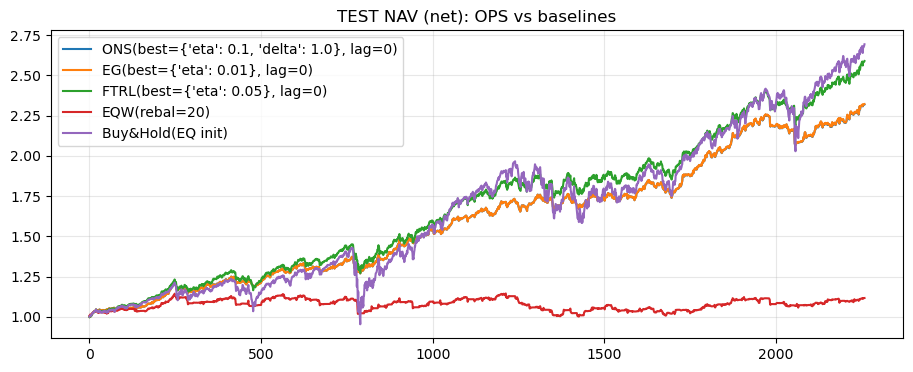

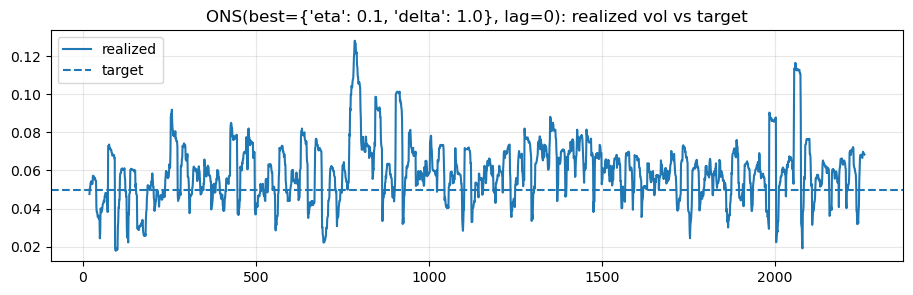

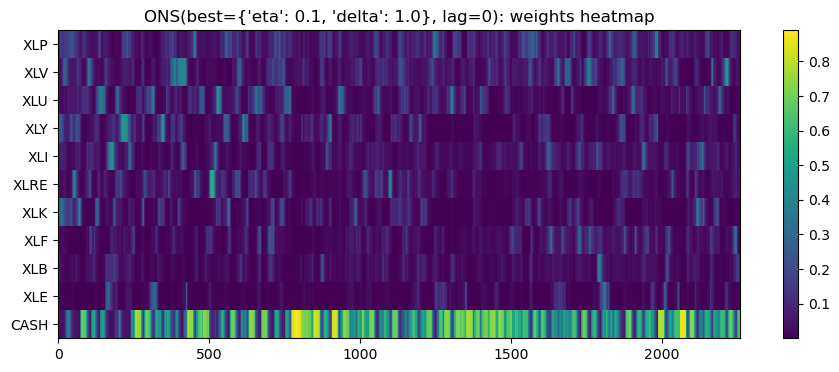

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ============================================================
# (A) Data loader (yfinance optional)
# ============================================================
def load_prices_yfinance(tickers, start="2015-01-01", end=None):
    import yfinance as yf
    df = yf.download(tickers, start=start, end=end, auto_adjust=True, progress=False)

    if isinstance(df.columns, pd.MultiIndex):
        if "Close" in df.columns.get_level_values(0):
            prices = df["Close"].copy()
        elif "Adj Close" in df.columns.get_level_values(0):
            prices = df["Adj Close"].copy()
        else:
            prices = df.xs(df.columns.get_level_values(0)[0], axis=1, level=0)
    else:
        prices = df[["Close"]] if "Close" in df.columns else df.copy()

    if isinstance(prices, pd.Series):
        prices = prices.to_frame()

    prices = prices.dropna(how="all").ffill().dropna()
    return prices


# ============================================================
# (B) Core utilities
# ============================================================
def price_relatives_from_prices(prices: pd.DataFrame) -> pd.DataFrame:
    x = prices / prices.shift(1)
    return x.dropna()

def project_to_simplex(v: np.ndarray, z: float = 1.0) -> np.ndarray:
    v = np.asarray(v, dtype=float).ravel()
    n = v.size
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u) - z
    ind = np.arange(1, n + 1)
    cond = u - cssv / ind > 0
    if not np.any(cond):
        w = np.zeros_like(v)
        w[np.argmax(v)] = z
        return w
    rho = ind[cond][-1]
    theta = cssv[cond][-1] / rho
    w = np.maximum(v - theta, 0.0)
    s = w.sum()
    if s <= 0:
        return np.ones_like(v) / n
    return w * (z / s)

def safe_softmax(a: np.ndarray, temp: float = 1.0) -> np.ndarray:
    a = np.asarray(a, dtype=float).ravel() / max(temp, 1e-12)
    a = a - np.max(a)
    ea = np.exp(a)
    return ea / max(ea.sum(), 1e-12)

def max_drawdown(nav: pd.Series) -> float:
    if len(nav) == 0:
        return np.nan
    peak = nav.cummax()
    dd = nav / peak - 1.0
    return float(dd.min())

def annualize_stats(ret_s: pd.Series, periods_per_year: int = 252) -> dict:
    if len(ret_s) == 0:
        return {"ann_return": np.nan, "ann_vol": np.nan, "sharpe": np.nan}
    mu = ret_s.mean()
    vol = ret_s.std(ddof=0)
    ann_ret = (1.0 + mu) ** periods_per_year - 1.0
    ann_vol = vol * np.sqrt(periods_per_year)
    sharpe = (mu / (vol + 1e-12)) * np.sqrt(periods_per_year)
    return {"ann_return": float(ann_ret), "ann_vol": float(ann_vol), "sharpe": float(sharpe)}

def realized_vol(ret_s: pd.Series, lookback: int = 20, periods_per_year: int = 252) -> pd.Series:
    if len(ret_s) == 0:
        return pd.Series(dtype=float)
    return ret_s.rolling(lookback).std(ddof=0) * np.sqrt(periods_per_year)

def turnover_l1(w_new: np.ndarray, w_old: np.ndarray) -> float:
    return float(np.sum(np.abs(w_new - w_old)))


# ============================================================
# (C) Side info signals (raw; lag applied at execution)
# ============================================================
def make_side_info_signals(prices: pd.DataFrame, mom_window: int = 20, vol_window: int = 20, clip: float = 3.0) -> pd.DataFrame:
    logp = np.log(prices)
    mom = logp - logp.shift(mom_window)
    lr = logp.diff()
    vol = lr.rolling(vol_window).std(ddof=0)

    def cs_zscore(df):
        mu = df.mean(axis=1)
        sd = df.std(axis=1, ddof=0).replace(0, np.nan)
        return (df.sub(mu, axis=0)).div(sd, axis=0)

    mom_z = cs_zscore(mom).clip(-clip, clip)
    vol_z = cs_zscore(vol).clip(-clip, clip)
    score = mom_z - vol_z
    return score.dropna(how="all")

def prior_from_signal(signal_row: np.ndarray, temp: float = 1.0) -> np.ndarray:
    return safe_softmax(signal_row, temp=temp)


# ============================================================
# (D) OPS algorithms
# ============================================================
class BaseOPS:
    def __init__(self, eps: float = 1e-12):
        self.eps = float(eps)
    def init_state(self, d: int): pass
    def step(self, w: np.ndarray, x_t: np.ndarray): raise NotImplementedError

class EGOPS(BaseOPS):
    def __init__(self, eta: float = 0.05, eps: float = 1e-12):
        super().__init__(eps); self.eta=float(eta)
    def step(self, w, x_t):
        denom = max(float(w @ x_t), self.eps)
        g = -x_t / denom
        w_new = w * np.exp(-self.eta * g)
        w_new = w_new / max(w_new.sum(), self.eps)
        return w_new

class ONSOPS(BaseOPS):
    def __init__(self, eta: float = 0.3, delta: float = 1.0, clip_grad: float = 1e3, eps: float = 1e-12):
        super().__init__(eps)
        self.eta=float(eta); self.delta=float(delta); self.clip_grad=float(clip_grad)
        self.invA=None
    def init_state(self, d: int):
        self.invA = (1.0 / self.delta) * np.eye(d)
    def step(self, w, x_t):
        denom = max(float(w @ x_t), self.eps)
        g = -x_t / denom
        g = np.clip(g, -self.clip_grad, self.clip_grad)
        invA_g = self.invA @ g
        denom_sm = 1.0 + float(g @ invA_g)
        self.invA = self.invA - np.outer(invA_g, invA_g) / max(denom_sm, self.eps)
        w_new = w - self.eta * (self.invA @ g)
        return project_to_simplex(w_new)

class FTRLLogBarrierOPS(BaseOPS):
    def __init__(self, eta: float = 0.2, eps: float = 1e-12, nu_tol: float = 1e-12):
        super().__init__(eps); self.eta=float(eta); self.nu_tol=float(nu_tol); self.G=None
    def init_state(self, d: int):
        self.G = np.zeros(d, dtype=float)
    def _solve_nu(self, G: np.ndarray) -> float:
        etaG = self.eta * G
        lo = -np.min(etaG) + 1e-12
        hi = lo + 1.0
        def f(nu):
            denom = etaG + nu
            return np.sum(1.0 / denom) - 1.0
        while f(hi) > 0:
            hi *= 2.0
            if hi > 1e12: break
        for _ in range(200):
            mid = 0.5*(lo+hi)
            val = f(mid)
            if abs(val) < self.nu_tol: return mid
            if val > 0: lo = mid
            else: hi = mid
        return 0.5*(lo+hi)
    def step(self, w, x_t):
        denom = max(float(w @ x_t), self.eps)
        g = -x_t / denom
        self.G = self.G + g
        nu = self._solve_nu(self.G)
        w_new = 1.0 / (self.eta * self.G + nu)
        w_new = np.maximum(w_new, 0.0)
        w_new = w_new / max(w_new.sum(), self.eps)
        return w_new


# ============================================================
# (E) Backtest engine (KeyError-free alignment + no-lookahead)
# ============================================================
def run_ops_backtest(
    prices: pd.DataFrame,
    algo: str = "ONS",
    cash_asset: bool = True,
    use_side_info: bool = True,
    side_info_temp: float = 1.0,
    blend_prior: float = 0.20,
    target_vol_ann: float = 0.10,
    vol_lookback: int = 20,
    periods_per_year: int = 252,
    commission_bps: float = 1.0,
    slippage_bps: float = 1.0,
    algo_params: dict = None,
    init_wealth: float = 1.0,
    w0: np.ndarray = None,
    execution_lag: int = 1,
    mom_window: int = 20,
    vol_window: int = 20,
    signal_clip: float = 3.0,
):
    if execution_lag < 0:
        raise ValueError("execution_lag must be >= 0")

    prices = prices.dropna().copy()

    x = price_relatives_from_prices(prices)
    if len(x) == 0:
        raise ValueError("No price relatives (x is empty). Check price data length/NaNs.")

    signal = None
    if use_side_info:
        signal = make_side_info_signals(prices, mom_window=mom_window, vol_window=vol_window, clip=signal_clip)

        # ---- FIX 1: use reindex (NOT .loc) to avoid KeyError ----
        # This aligns to x.index inserting NaNs for missing dates, then we drop NaNs safely.
        signal = signal.reindex(x.index)

        # drop rows where all assets are NaN (still safe)
        signal = signal.dropna(how="all")

        # ---- FIX 2: apply execution lag AFTER alignment ----
        if execution_lag > 0:
            signal = signal.shift(execution_lag)

        # now we need dates where signal is valid for all assets we use (or at least not all NaN)
        signal = signal.dropna(how="all")

        # align x to remaining signal dates (safe intersection)
        common_idx = x.index.intersection(signal.index)
        x = x.loc[common_idx]
        signal = signal.loc[common_idx]

        if len(x) == 0:
            raise ValueError(
                "After aligning signals and applying execution_lag, no samples remain. "
                "Try earlier split_date / longer history, or reduce mom/vol windows."
            )

    if cash_asset:
        x = x.copy()
        x["CASH"] = 1.0
        if use_side_info and signal is not None:
            signal = signal.copy()
            signal["CASH"] = 0.0

    X = x.to_numpy(dtype=float)
    T, d = X.shape
    asset_names = list(x.columns)

    algo_params = {} if algo_params is None else dict(algo_params)
    algo_u = algo.upper()
    if algo_u == "ONS":
        model = ONSOPS(**algo_params); model.init_state(d)
    elif algo_u == "EG":
        model = EGOPS(**algo_params)
    elif algo_u == "FTRL":
        model = FTRLLogBarrierOPS(**algo_params); model.init_state(d)
    else:
        raise ValueError("algo must be 'ONS'|'EG'|'FTRL'")

    w = np.ones(d)/d if w0 is None else project_to_simplex(w0)

    weights = np.zeros((T, d))
    ret_gross = np.zeros(T)
    ret_net = np.zeros(T)
    turnover = np.zeros(T)
    cost = np.zeros(T)

    tc = (commission_bps + slippage_bps) * 1e-4
    ret_net_hist = []

    for t in range(T):
        xt = X[t]

        # prior blend (lagged signal)
        if use_side_info and signal is not None:
            srow = signal.iloc[t].to_numpy(dtype=float)
            if np.all(np.isnan(srow)):
                # if a date has no signal (should be rare after dropna), skip blending
                pass
            else:
                # replace NaN with 0 before softmax to keep stable
                srow = np.nan_to_num(srow, nan=0.0)
                w_prior = prior_from_signal(srow, temp=side_info_temp)
                w = project_to_simplex((1.0 - blend_prior) * w + blend_prior * w_prior)

        # vol targeting uses past realized net returns
        if cash_asset and (target_vol_ann is not None) and (len(ret_net_hist) >= vol_lookback):
            past = pd.Series(ret_net_hist[-vol_lookback:])
            rv = float(past.std(ddof=0) * np.sqrt(periods_per_year))
            rv = max(rv, 1e-12)
            alpha = min(1.0, target_vol_ann / rv)
            cash_idx = asset_names.index("CASH")
            w_cash = np.zeros_like(w); w_cash[cash_idx] = 1.0
            w = project_to_simplex(alpha * w + (1.0 - alpha) * w_cash)

        gross_growth = float(w @ xt)
        gross_growth = max(gross_growth, 1e-12)
        rg = gross_growth - 1.0

        if t == 0:
            to = 0.0
        else:
            to = turnover_l1(w, weights[t-1])
        c = tc * to
        rn = rg - c

        weights[t] = w
        ret_gross[t] = rg
        turnover[t] = to
        cost[t] = c
        ret_net[t] = rn
        ret_net_hist.append(rn)

        w = model.step(w, xt)

    idx = x.index
    w_df = pd.DataFrame(weights, index=idx, columns=asset_names)
    rg_s = pd.Series(ret_gross, index=idx, name="ret_gross")
    rn_s = pd.Series(ret_net, index=idx, name="ret_net")
    to_s = pd.Series(turnover, index=idx, name="turnover")
    c_s  = pd.Series(cost, index=idx, name="cost")

    nav_g = (1.0 + rg_s).cumprod() * init_wealth
    nav_n = (1.0 + rn_s).cumprod() * init_wealth
    nav_g.name = "nav_gross"; nav_n.name = "nav_net"

    rv_n = realized_vol(rn_s, lookback=vol_lookback, periods_per_year=periods_per_year)
    rv_n.name = "realized_vol_ann"

    stats = annualize_stats(rn_s, periods_per_year=periods_per_year)
    summary = {
        **stats,
        "max_drawdown": float(max_drawdown(nav_n)),
        "avg_turnover": float(to_s.mean()),
        "total_cost": float(c_s.sum()),
        "final_nav_net": float(nav_n.iloc[-1]),
        "nobs": int(len(rn_s)),
        "execution_lag": int(execution_lag),
    }

    return {
        "weights": w_df,
        "ret_gross": rg_s,
        "ret_net": rn_s,
        "nav_gross": nav_g,
        "nav_net": nav_n,
        "turnover": to_s,
        "cost": c_s,
        "realized_vol_ann": rv_n,
        "summary": summary,
        "price_relatives": x,
    }


# ============================================================
# (F) Baselines
# ============================================================
def run_eqw_backtest(
    prices: pd.DataFrame,
    rebalance_every: int = 1,
    cash_asset: bool = True,
    target_vol_ann: float = 0.10,
    vol_lookback: int = 20,
    periods_per_year: int = 252,
    commission_bps: float = 1.0,
    slippage_bps: float = 1.0,
    init_wealth: float = 1.0,
):
    prices = prices.dropna().copy()
    x = price_relatives_from_prices(prices)
    if len(x) == 0:
        raise ValueError("EQW: No price relatives. Check price data length/NaNs.")

    if cash_asset:
        x = x.copy()
        x["CASH"] = 1.0

    X = x.to_numpy(dtype=float)
    T, d = X.shape
    asset_names = list(x.columns)
    tc = (commission_bps + slippage_bps) * 1e-4

    w = np.ones(d)/d
    weights = np.zeros((T,d))
    rn = np.zeros(T)
    to = np.zeros(T)
    c  = np.zeros(T)
    ret_net_hist = []

    for t in range(T):
        if (t == 0) or (rebalance_every > 0 and (t % rebalance_every == 0)):
            w_target = np.ones(d)/d
        else:
            w_target = w

        if cash_asset and (target_vol_ann is not None) and (len(ret_net_hist) >= vol_lookback):
            past = pd.Series(ret_net_hist[-vol_lookback:])
            rv = float(past.std(ddof=0) * np.sqrt(periods_per_year))
            rv = max(rv, 1e-12)
            alpha = min(1.0, target_vol_ann / rv)
            cash_idx = asset_names.index("CASH")
            w_cash = np.zeros(d); w_cash[cash_idx] = 1.0
            w_target = project_to_simplex(alpha*w_target + (1.0-alpha)*w_cash)

        if t == 0:
            to_t = 0.0
        else:
            to_t = turnover_l1(w_target, weights[t-1])
        cost_t = tc * to_t

        growth = float(w_target @ X[t]); growth = max(growth, 1e-12)
        rn_t = (growth - 1.0) - cost_t

        weights[t] = w_target
        rn[t] = rn_t
        to[t] = to_t
        c[t]  = cost_t
        ret_net_hist.append(rn_t)
        w = w_target

    idx = x.index
    w_df = pd.DataFrame(weights, index=idx, columns=asset_names)
    rn_s = pd.Series(rn, index=idx, name="ret_net")
    to_s = pd.Series(to, index=idx, name="turnover")
    c_s  = pd.Series(c, index=idx, name="cost")
    nav_n = (1.0 + rn_s).cumprod() * init_wealth
    nav_n.name = "nav_net"

    rv_n = realized_vol(rn_s, lookback=vol_lookback, periods_per_year=periods_per_year)

    stats = annualize_stats(rn_s, periods_per_year=periods_per_year)
    summary = {
        **stats,
        "max_drawdown": float(max_drawdown(nav_n)),
        "avg_turnover": float(to_s.mean()),
        "total_cost": float(c_s.sum()),
        "final_nav_net": float(nav_n.iloc[-1]),
        "nobs": int(len(rn_s)),
    }

    return {
        "weights": w_df, "ret_net": rn_s, "nav_net": nav_n,
        "turnover": to_s, "cost": c_s, "realized_vol_ann": rv_n,
        "summary": summary, "price_relatives": x
    }

def run_buyhold_backtest(prices: pd.DataFrame, cash_asset: bool = True, init_wealth: float = 1.0):
    prices = prices.dropna().copy()
    x = price_relatives_from_prices(prices)
    if len(x) == 0:
        raise ValueError("Buy&Hold: No price relatives. Check price data length/NaNs.")

    p = prices.loc[x.index].copy()
    if cash_asset:
        p = p.copy()
        p["CASH"] = 1.0

    d = p.shape[1]
    w0 = np.ones(d)/d
    base = p.iloc[0]
    rel = p.div(base, axis=1)
    nav = ((rel * w0).sum(axis=1) * init_wealth).rename("nav_net")
    ret = nav.pct_change().fillna(0.0).rename("ret_net")

    stats = annualize_stats(ret)
    summary = {
        **stats,
        "max_drawdown": float(max_drawdown(nav)),
        "avg_turnover": 0.0,
        "total_cost": 0.0,
        "final_nav_net": float(nav.iloc[-1]),
        "nobs": int(len(ret)),
    }
    return {"nav_net": nav, "ret_net": ret, "summary": summary}


# ============================================================
# (G) Walk-forward (robust)
# ============================================================
def grid_search_train(prices_train, algo, grid, **common_kwargs):
    best = None
    best_pair = None
    failures = 0

    for params in grid:
        try:
            out = run_ops_backtest(prices_train, algo=algo, algo_params=params, **common_kwargs)
            sharpe = out["summary"]["sharpe"]
            if np.isnan(sharpe):
                failures += 1
                continue
            if (best is None) or (sharpe > best):
                best = sharpe
                best_pair = (params, out)
        except ValueError:
            failures += 1
            continue

    if best_pair is None:
        raise ValueError(
            f"All grid candidates failed on TRAIN for algo={algo}. "
            "Likely train window too short after (signal windows + execution_lag) alignment, or many NaNs."
        )
    return best_pair

def walk_forward_run(prices, split_date, algo="ONS", grid=None, **common_kwargs):
    split_date = pd.to_datetime(split_date)
    prices = prices.dropna().copy()

    prices_tr = prices.loc[:split_date].copy()
    prices_te = prices.loc[split_date:].copy()
    if len(prices_tr) < 50 or len(prices_te) < 50:
        raise ValueError("Train/test split too small. Choose split_date with sufficient samples.")

    if grid is None:
        if algo.upper() == "ONS":
            grid = [{"eta": e, "delta": 1.0} for e in [0.10, 0.20, 0.30, 0.40]]
        elif algo.upper() == "EG":
            grid = [{"eta": e} for e in [0.01, 0.03, 0.05, 0.08, 0.10]]
        elif algo.upper() == "FTRL":
            grid = [{"eta": e} for e in [0.05, 0.10, 0.20, 0.30, 0.50]]
        else:
            raise ValueError("unknown algo")

    best_params, out_tr = grid_search_train(prices_tr, algo=algo, grid=grid, **common_kwargs)
    out_te = run_ops_backtest(prices_te, algo=algo, algo_params=best_params, **common_kwargs)
    return {"best_params": best_params, "train": out_tr, "test": out_te}


# ============================================================
# (H) Reporting
# ============================================================
def summary_table(outputs: dict) -> pd.DataFrame:
    rows = []
    for name, out in outputs.items():
        s = out["summary"].copy()
        s["name"] = name
        rows.append(s)
    return pd.DataFrame(rows).set_index("name").sort_values("sharpe", ascending=False)

def plot_nav(outputs: dict, title="NAV (net)"):
    plt.figure(figsize=(11,4))
    for name, out in outputs.items():
        plt.plot(out["nav_net"].values, label=name)
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

def plot_realized_vol(out: dict, target_vol_ann=None, title="Realized vol (ann)"):
    if "realized_vol_ann" not in out:
        return
    plt.figure(figsize=(11,3))
    plt.plot(out["realized_vol_ann"].values, label="realized")
    if target_vol_ann is not None:
        plt.axhline(target_vol_ann, linestyle="--", label="target")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

def plot_weights_heatmap(out: dict, max_assets=15, title="Weights heatmap"):
    if "weights" not in out:
        return
    w = out["weights"].copy()
    cols = list(w.columns)
    if "CASH" in cols:
        risky = [c for c in cols if c != "CASH"]
        avg = w[risky].mean().sort_values(ascending=False)
        keep = list(avg.index[:max_assets-1]) + ["CASH"]
        w = w[keep]
    else:
        avg = w.mean().sort_values(ascending=False)
        w = w[list(avg.index[:max_assets])]

    plt.figure(figsize=(11,4))
    plt.imshow(w.T.values, aspect="auto", interpolation="nearest")
    plt.yticks(range(len(w.columns)), w.columns)
    plt.title(title)
    plt.colorbar()
    plt.show()


# ============================================================
# (I) ONE-SHOT runner
# ============================================================
def run_everything(
    prices: pd.DataFrame,
    split_date: str,
    cash_asset=True,
    use_side_info=True,
    blend_prior=0.20,
    side_info_temp=1.0,
    target_vol_ann=0.10,
    vol_lookback=20,
    commission_bps=1.0,
    slippage_bps=1.0,
    eqw_rebalance_every=20,
    execution_lag=1,
    mom_window=20,
    vol_window=20,
):
    common = dict(
        cash_asset=cash_asset,
        use_side_info=use_side_info,
        blend_prior=blend_prior,
        side_info_temp=side_info_temp,
        target_vol_ann=target_vol_ann,
        vol_lookback=vol_lookback,
        commission_bps=commission_bps,
        slippage_bps=slippage_bps,
        execution_lag=execution_lag,
        mom_window=mom_window,
        vol_window=vol_window,
    )

    res_ons = walk_forward_run(prices, split_date, algo="ONS", **common)
    res_eg  = walk_forward_run(prices, split_date, algo="EG",  **common)
    res_ft  = walk_forward_run(prices, split_date, algo="FTRL",**common)

    prices_te = prices.loc[pd.to_datetime(split_date):].dropna().copy()
    eqw = run_eqw_backtest(
        prices_te,
        rebalance_every=eqw_rebalance_every,
        cash_asset=cash_asset,
        target_vol_ann=target_vol_ann,
        vol_lookback=vol_lookback,
        commission_bps=commission_bps,
        slippage_bps=slippage_bps,
    )
    bh = run_buyhold_backtest(prices_te, cash_asset=cash_asset)

    outs = {
        f"ONS(best={res_ons['best_params']}, lag={execution_lag})": res_ons["test"],
        f"EG(best={res_eg['best_params']}, lag={execution_lag})":  res_eg["test"],
        f"FTRL(best={res_ft['best_params']}, lag={execution_lag})":res_ft["test"],
        f"EQW(rebal={eqw_rebalance_every})": eqw,
        "Buy&Hold(EQ init)": bh,
    }

    # align indices for fair comparison
    common_idx = None
    for out in outs.values():
        idx = out["nav_net"].index
        common_idx = idx if common_idx is None else common_idx.intersection(idx)
    for k in list(outs.keys()):
        outs[k] = outs[k].copy()
        outs[k]["nav_net"] = outs[k]["nav_net"].loc[common_idx]
        outs[k]["ret_net"] = outs[k]["ret_net"].loc[common_idx]

    print("=== Best params (selected on TRAIN Sharpe) ===")
    print("ONS :", res_ons["best_params"])
    print("EG  :", res_eg["best_params"])
    print("FTRL:", res_ft["best_params"])

    df_sum = summary_table(outs)
    print("\n=== TEST summary (net) ===")
    display(df_sum)

    plot_nav(outs, title="TEST NAV (net): OPS vs baselines")
    k0 = [k for k in outs.keys() if k.startswith("ONS")][0]
    plot_realized_vol(outs[k0], target_vol_ann=target_vol_ann, title=f"{k0}: realized vol vs target")
    plot_weights_heatmap(outs[k0], title=f"{k0}: weights heatmap")

    return {"walk": {"ONS":res_ons, "EG":res_eg, "FTRL":res_ft}, "test_outputs": outs, "summary": df_sum}


# ============================================================
# (J) EDIT HERE and RUN
# ============================================================

TICKERS = ["XLB", "XLE", "XLF", "XLI", "XLK", "XLP", "XLU", "XLV", "XLY", "XLRE"]
START_DATE = "2011-01-01"
END_DATE = "2026-01-31"
np.random.seed(42)
SPLIT_DATE = "2017-01-01"

# ---- Load prices ----
prices = load_prices_yfinance(TICKERS, start=START_DATE, end=END_DATE)

out = run_everything(
    prices=prices,
    split_date=SPLIT_DATE,
    cash_asset=True,
    use_side_info=True,
    blend_prior=0.20,
    side_info_temp=1.0,
    target_vol_ann=0.05,
    vol_lookback=20,
    commission_bps=1.0,
    slippage_bps=1.0,
    eqw_rebalance_every=20,
    execution_lag=0,
    mom_window=20,   # <- if still too short, reduce to 10
    vol_window=20,   # <- if still too short, reduce to 10
)

      ann_return   ann_vol    sharpe  max_drawdown  avg_turnover  total_cost  \
name                                                                           
FTRL    0.099253  0.109070  0.867775     -0.174667      0.058072    0.029837   
PPO     0.081974  0.108807  0.724211     -0.181522      0.090535    0.040904   
EG      0.066870  0.096624  0.669992     -0.138628      0.090310    0.046401   
ONS     0.066451  0.096539  0.666509     -0.137969      0.094448    0.048527   

      final_nav_net  final_nav_gross  nobs  
name                                        
FTRL       2.469311         2.544092  2569  
PPO        1.921442         2.001656  2259  
EG         1.844390         1.931980  2569  
ONS        1.837174         1.928517  2569  


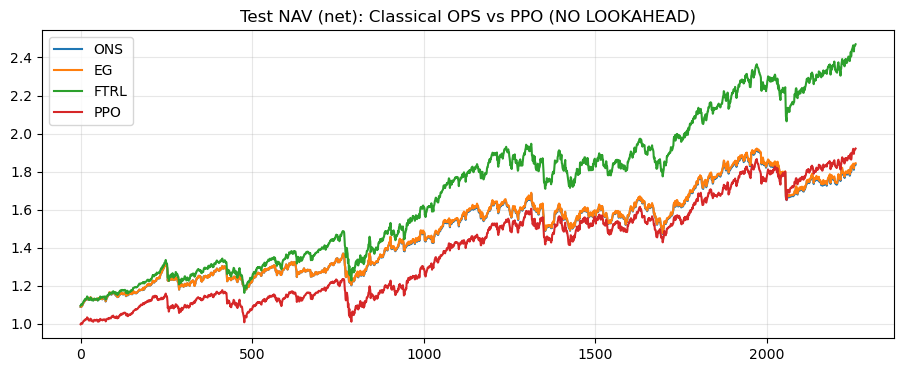

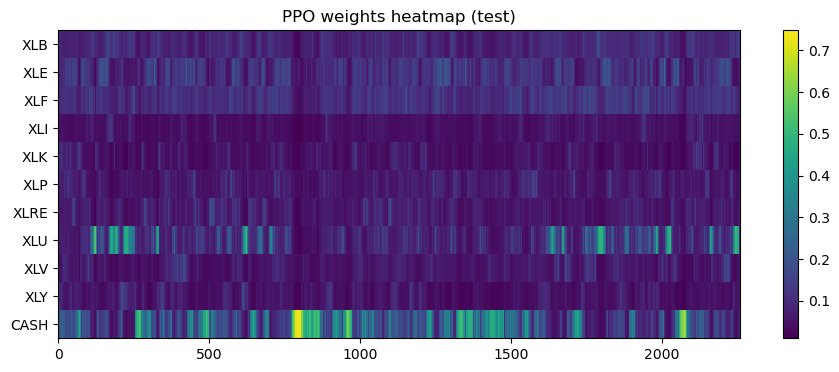

In [9]:
import numpy as np
import pandas as pd

# ============================================================
# 0) Utilities
# ============================================================
def price_relatives_from_prices(prices: pd.DataFrame) -> pd.DataFrame:
    x = prices / prices.shift(1)
    return x.dropna()

def project_to_simplex(v: np.ndarray, z: float = 1.0) -> np.ndarray:
    v = np.asarray(v, dtype=float).ravel()
    n = v.size
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u) - z
    ind = np.arange(1, n + 1)
    cond = u - cssv / ind > 0
    if not np.any(cond):
        w = np.zeros_like(v)
        w[np.argmax(v)] = z
        return w
    rho = ind[cond][-1]
    theta = cssv[cond][-1] / rho
    w = np.maximum(v - theta, 0.0)
    s = w.sum()
    if s <= 0:
        return np.ones_like(v) / n
    return w * (z / s)

def safe_softmax(a: np.ndarray, temp: float = 1.0) -> np.ndarray:
    a = np.asarray(a, dtype=float).ravel()
    a = a / max(temp, 1e-12)
    a = a - np.max(a)
    ea = np.exp(a)
    return ea / max(ea.sum(), 1e-12)

def annualize_stats(ret_s: pd.Series, periods_per_year: int = 252) -> dict:
    mu = ret_s.mean()
    vol = ret_s.std(ddof=0)
    ann_ret = (1.0 + mu) ** periods_per_year - 1.0
    ann_vol = vol * np.sqrt(periods_per_year)
    sharpe = (mu / (vol + 1e-12)) * np.sqrt(periods_per_year)
    return {"ann_return": float(ann_ret), "ann_vol": float(ann_vol), "sharpe": float(sharpe)}

def max_drawdown(nav: pd.Series) -> float:
    peak = nav.cummax()
    dd = nav / peak - 1.0
    return float(dd.min())

def realized_vol(ret_s: pd.Series, lookback: int = 20, periods_per_year: int = 252) -> pd.Series:
    return ret_s.rolling(lookback).std(ddof=0) * np.sqrt(periods_per_year)

def turnover_l1(w_new: np.ndarray, w_old: np.ndarray) -> float:
    return float(np.sum(np.abs(w_new - w_old)))

def align_series_to_index(s: pd.Series, idx: pd.Index, name="VIX") -> pd.Series:
    s = s.copy()
    s.index = pd.to_datetime(s.index)
    s = s.sort_index()
    s = s.reindex(idx).ffill()
    s.name = name
    return s

# (optional) data loaders used in your example section
def load_prices_yfinance(tickers, start="2011-01-01", end=None) -> pd.DataFrame:
    import yfinance as yf
    df = yf.download(tickers, start=start, end=end, auto_adjust=True, progress=False)["Close"]
    if isinstance(df, pd.Series):
        df = df.to_frame(tickers if isinstance(tickers, str) else tickers[0])
    df = df.dropna(how="all")
    return df

def load_vix_yfinance(start="2011-01-01", end=None) -> pd.Series:
    import yfinance as yf
    df = yf.download("^VIX", start=start, end=end, auto_adjust=True, progress=False)
    v = df["Close"] if "Close" in df.columns else df.iloc[:, 0]
    v = v.dropna()
    v.name = "VIX"
    return v

# ============================================================
# 1) Side-information signals (optional; NO LOOKAHEAD version)
# ============================================================
def make_side_info_signals(prices: pd.DataFrame, mom_window=20, vol_window=20, clip=3.0) -> pd.DataFrame:
    """
    Raw signals are computed at time t using prices up to t.
    To avoid lookahead when used for trading return x_t = P_t/P_{t-1},
    we will LAG signals by 1 (use signal_{t-1} for return x_t).

    This function returns UNLAGGED scores; caller will shift(1) safely.
    """
    logp = np.log(prices)
    mom = logp - logp.shift(mom_window)
    lr = logp.diff()
    vol = lr.rolling(vol_window).std(ddof=0)

    def cs_zscore(df):
        mu = df.mean(axis=1)
        sd = df.std(axis=1, ddof=0).replace(0, np.nan)
        return (df.sub(mu, axis=0)).div(sd, axis=0)

    mom_z = cs_zscore(mom).clip(-clip, clip)
    vol_z = cs_zscore(vol).clip(-clip, clip)
    score = (mom_z - vol_z).dropna()
    return score

def prior_from_signal(signal_row: np.ndarray, temp: float = 1.0) -> np.ndarray:
    return safe_softmax(signal_row, temp=temp)

# ============================================================
# 2) Classical OPS algorithms: EG / ONS / FTRL(log-barrier)
# ============================================================
class BaseOPS:
    def __init__(self, eps: float = 1e-12):
        self.eps = float(eps)
    def init_state(self, d: int):
        pass
    def step(self, w: np.ndarray, x_t: np.ndarray) -> np.ndarray:
        raise NotImplementedError

class EGOPS(BaseOPS):
    def __init__(self, eta: float = 0.05, eps: float = 1e-12):
        super().__init__(eps); self.eta=float(eta)
    def step(self, w, x_t):
        denom = max(float(w @ x_t), self.eps)
        g = -x_t / denom
        w_new = w * np.exp(-self.eta * g)
        w_new = w_new / max(w_new.sum(), self.eps)
        return w_new

class ONSOPS(BaseOPS):
    def __init__(self, eta: float = 0.3, delta: float = 1.0, clip_grad: float = 1e3, eps: float = 1e-12):
        super().__init__(eps)
        self.eta=float(eta); self.delta=float(delta); self.clip_grad=float(clip_grad)
        self.invA=None
    def init_state(self, d: int):
        self.invA = (1.0 / self.delta) * np.eye(d)
    def step(self, w, x_t):
        denom = max(float(w @ x_t), self.eps)
        g = -x_t / denom
        g = np.clip(g, -self.clip_grad, self.clip_grad)

        invA_g = self.invA @ g
        denom_sm = 1.0 + float(g @ invA_g)
        self.invA = self.invA - np.outer(invA_g, invA_g) / max(denom_sm, self.eps)

        w_new = w - self.eta * (self.invA @ g)
        return project_to_simplex(w_new)

class FTRLLogBarrierOPS(BaseOPS):
    """
    R(w) = -sum log w_i
    w_i = 1/(eta*G_i + nu), choose nu s.t. sum w_i = 1
    """
    def __init__(self, eta: float = 0.2, eps: float = 1e-12, nu_tol: float = 1e-12):
        super().__init__(eps)
        self.eta=float(eta); self.nu_tol=float(nu_tol)
        self.G=None
    def init_state(self, d: int):
        self.G = np.zeros(d, dtype=float)
    def _solve_nu(self, G: np.ndarray) -> float:
        etaG = self.eta * G
        lo = -np.min(etaG) + 1e-12
        hi = lo + 1.0

        def f(nu):
            denom = etaG + nu
            return np.sum(1.0 / denom) - 1.0

        while f(hi) > 0:
            hi *= 2.0
            if hi > 1e12:
                break

        for _ in range(200):
            mid = 0.5*(lo+hi)
            val = f(mid)
            if abs(val) < self.nu_tol:
                return mid
            if val > 0:
                lo = mid
            else:
                hi = mid
        return 0.5*(lo+hi)

    def step(self, w, x_t):
        denom = max(float(w @ x_t), self.eps)
        g = -x_t / denom
        self.G = self.G + g
        nu = self._solve_nu(self.G)

        w_new = 1.0 / (self.eta * self.G + nu)
        w_new = np.maximum(w_new, 0.0)
        w_new = w_new / max(w_new.sum(), self.eps)
        return w_new

# ============================================================
# 3) Shared post-processing
# ============================================================
def apply_prior_and_vol_targeting(
    w: np.ndarray,
    signal_row: np.ndarray,
    side_info_temp: float,
    blend_prior: float,
    cash_asset: bool,
    asset_names: list[str],
    target_vol_ann: float,
    vol_lookback: int,
    periods_per_year: int,
    ret_net_hist: list[float],
) -> np.ndarray:
    # (A) side-info prior blending
    if signal_row is not None:
        w_prior = prior_from_signal(signal_row, temp=side_info_temp)
        w = project_to_simplex((1.0 - blend_prior) * w + blend_prior * w_prior)

    # (B) vol targeting by mixing into CASH (de-risk only)
    if cash_asset and (target_vol_ann is not None) and (len(ret_net_hist) >= vol_lookback):
        past = np.asarray(ret_net_hist[-vol_lookback:], dtype=float)
        rv = float(np.std(past, ddof=0) * np.sqrt(periods_per_year))
        rv = max(rv, 1e-12)
        alpha = min(1.0, target_vol_ann / rv)

        cash_idx = asset_names.index("CASH")
        w_cash = np.zeros_like(w); w_cash[cash_idx] = 1.0
        w = project_to_simplex(alpha * w + (1.0 - alpha) * w_cash)

    return w

def finalize_outputs(
    x: pd.DataFrame,
    weights: np.ndarray,
    ret_gross: np.ndarray,
    ret_net: np.ndarray,
    turnover: np.ndarray,
    cost: np.ndarray,
    vol_lookback: int,
    periods_per_year: int,
    init_wealth: float,
) -> dict:
    idx = x.index
    w_df = pd.DataFrame(weights, index=idx, columns=x.columns)
    rg_s = pd.Series(ret_gross, index=idx, name="ret_gross")
    rn_s = pd.Series(ret_net, index=idx, name="ret_net")
    to_s = pd.Series(turnover, index=idx, name="turnover")
    c_s  = pd.Series(cost, index=idx, name="cost")

    nav_g = (1.0 + rg_s).cumprod() * init_wealth
    nav_n = (1.0 + rn_s).cumprod() * init_wealth
    nav_g.name = "nav_gross"
    nav_n.name = "nav_net"

    rv_n = realized_vol(rn_s, lookback=vol_lookback, periods_per_year=periods_per_year)
    rv_n.name = "realized_vol_ann"

    stats = annualize_stats(rn_s, periods_per_year=periods_per_year)
    summary = {
        **stats,
        "max_drawdown": float(max_drawdown(nav_n)),
        "avg_turnover": float(to_s.mean()),
        "total_cost": float(c_s.sum()),
        "final_nav_net": float(nav_n.iloc[-1]),
        "final_nav_gross": float(nav_g.iloc[-1]),
        "nobs": int(len(rn_s)),
    }

    return {
        "weights": w_df,
        "ret_gross": rg_s,
        "ret_net": rn_s,
        "nav_gross": nav_g,
        "nav_net": nav_n,
        "turnover": to_s,
        "cost": c_s,
        "realized_vol_ann": rv_n,
        "summary": summary,
        "price_relatives": x,
    }

# ============================================================
# 4) Classical backtest (NO LOOKAHEAD)
#    - IMPORTANT: signal is shifted by 1 so that signal at time t
#      uses only info up to t-1 when trading x_t = P_t/P_{t-1}.
# ============================================================
def run_ops_backtest_classical(
    prices: pd.DataFrame,
    algo: str = "ONS",                 # "ONS"|"EG"|"FTRL"
    cash_asset: bool = True,
    use_side_info: bool = True,
    side_info_temp: float = 1.0,
    blend_prior: float = 0.20,
    target_vol_ann: float = 0.10,
    vol_lookback: int = 20,
    periods_per_year: int = 252,
    commission_bps: float = 1.0,
    slippage_bps: float = 1.0,
    algo_params: dict = None,
    init_wealth: float = 1.0,
    w0: np.ndarray = None,
):
    prices = prices.dropna().copy()

    # Raw signals (time t uses prices up to t)
    signal_raw = None
    if use_side_info:
        signal_raw = make_side_info_signals(prices)

    # returns x_t (index t corresponds to P_t / P_{t-1})
    x = price_relatives_from_prices(prices)

    # ---- NO LOOKAHEAD: lag signal by 1 relative to x ----
    # We will use signal_{t-1} when earning x_t.
    signal = None
    if use_side_info and (signal_raw is not None):
        signal = signal_raw.shift(1)

    # SAFE align signal and x
    if use_side_info and (signal is not None):
        signal = signal.reindex(x.index)

        # require signal available (after shift) to avoid accidental t-use
        valid = signal.dropna().index
        x = x.loc[valid]
        signal = signal.loc[valid]

    if cash_asset:
        x = x.copy()
        x["CASH"] = 1.0
        if use_side_info and (signal is not None):
            signal = signal.copy()
            signal["CASH"] = 0.0

    X = x.to_numpy(dtype=float)
    T, d = X.shape
    asset_names = list(x.columns)

    algo_params = {} if algo_params is None else dict(algo_params)
    au = algo.upper()
    if au == "ONS":
        model = ONSOPS(**algo_params); model.init_state(d)
    elif au == "EG":
        model = EGOPS(**algo_params)
    elif au == "FTRL":
        model = FTRLLogBarrierOPS(**algo_params); model.init_state(d)
    else:
        raise ValueError("classical algo must be 'ONS'|'EG'|'FTRL'")

    w = np.ones(d)/d if w0 is None else project_to_simplex(w0)

    weights = np.zeros((T, d))
    ret_gross = np.zeros(T)
    ret_net = np.zeros(T)
    turnover = np.zeros(T)
    cost = np.zeros(T)

    tc = (commission_bps + slippage_bps) * 1e-4
    ret_net_hist: list[float] = []

    for t in range(T):
        xt = X[t]

        # NO LOOKAHEAD: signal has already been shifted,
        # so signal.iloc[t] corresponds to original time (x.index[t]-1)
        srow = None
        if use_side_info and (signal is not None):
            srow = signal.iloc[t].to_numpy(dtype=float)

        w_exec = apply_prior_and_vol_targeting(
            w=w,
            signal_row=srow,
            side_info_temp=side_info_temp,
            blend_prior=blend_prior,
            cash_asset=cash_asset,
            asset_names=asset_names,
            target_vol_ann=target_vol_ann,
            vol_lookback=vol_lookback,
            periods_per_year=periods_per_year,
            ret_net_hist=ret_net_hist,
        )

        growth = float(w_exec @ xt); growth = max(growth, 1e-12)
        rg = growth - 1.0

        to = 0.0 if t == 0 else turnover_l1(w_exec, weights[t-1])
        c = tc * to
        rn = rg - c

        weights[t] = w_exec
        ret_gross[t] = rg
        ret_net[t] = rn
        turnover[t] = to
        cost[t] = c
        ret_net_hist.append(rn)

        w = model.step(w_exec, xt)

    return finalize_outputs(
        x=x,
        weights=weights,
        ret_gross=ret_gross,
        ret_net=ret_net,
        turnover=turnover,
        cost=cost,
        vol_lookback=vol_lookback,
        periods_per_year=periods_per_year,
        init_wealth=init_wealth,
    )

# ============================================================
# 5) PPO integration (NO LOOKAHEAD)
#    - signals are shifted(1) before use in env
#    - VIX feature is constructed without forward fill across future (ffill is OK)
#    - split has NO overlapping dates (train end < test start)
# ============================================================
def build_obs_matrix(
    x: pd.DataFrame,
    lookback: int,
    include_prev_w: bool,
    include_signal: bool,
    signal: pd.DataFrame,
    exog: np.ndarray = None,   # (T, k), aligned to x.index
):
    X = x.to_numpy(dtype=float)
    logx = np.log(np.maximum(X, 1e-12))
    T, d = X.shape

    sig_arr = None
    if include_signal and (signal is not None):
        sig_arr = signal.to_numpy(dtype=float)

    k = 0 if exog is None else int(exog.shape[1])

    def obs_dim_base():
        dim = lookback * d
        if include_prev_w:
            dim += d
        if include_signal and (sig_arr is not None):
            dim += d
        if exog is not None:
            dim += lookback * k
        return dim

    return X, logx, sig_arr, exog, obs_dim_base()

def simplex_from_action(action: np.ndarray, temp: float = 1.0) -> np.ndarray:
    return safe_softmax(action, temp=temp)

def run_ppo_backtest_same_outputs(
    prices: pd.DataFrame,
    cash_asset: bool = True,
    use_side_info: bool = True,
    side_info_temp: float = 1.0,
    blend_prior: float = 0.20,
    target_vol_ann: float = 0.10,
    vol_lookback: int = 20,
    periods_per_year: int = 252,
    commission_bps: float = 1.0,
    slippage_bps: float = 1.0,
    init_wealth: float = 1.0,
    # PPO-specific
    obs_lookback: int = 20,
    action_temp: float = 1.0,
    include_prev_w: bool = True,
    include_signal_in_obs: bool = True,
    reward_type: str = "log_net",   # "log_net"|"net"| "log_mv_turn"
    # training
    split_date: str = None,
    total_timesteps: int = 200_000,
    seed: int = 0,
    ppo_kwargs: dict = None,
    # VIX exogenous feature
    vix: pd.Series = None,
    vix_mode: str = "logret",          # "level" | "logret" | "zlevel"
    include_vix_in_obs: bool = True,
    # history in observation
    hist_len: int = 5,
    include_hist_actions: bool = True,
    include_hist_rewards: bool = True,
    include_hist_returns: bool = True,
    include_port_state: bool = True,
    # mean-variance + turnover suppression
    mv_lambda: float = 5.0,
    mv_ewm_span: int = 60,
    mv_use_instant: bool = False,
    turn_lambda: float = 0.05,
    turn_mode: str = "l1",
):
    import gymnasium as gym
    from gymnasium import spaces
    from stable_baselines3 import PPO

    prices = prices.dropna().copy()

    # signals (raw then shifted)
    signal_raw = None
    if use_side_info:
        signal_raw = make_side_info_signals(prices)

    x = price_relatives_from_prices(prices)

    # ---- NO LOOKAHEAD: lag signal by 1 relative to x ----
    signal = None
    if use_side_info and (signal_raw is not None):
        signal = signal_raw.shift(1)

    # SAFE align signal and x
    if use_side_info and (signal is not None):
        signal = signal.reindex(x.index)
        valid = signal.dropna().index
        x = x.loc[valid]
        signal = signal.loc[valid]

    if cash_asset:
        x = x.copy()
        x["CASH"] = 1.0
        if use_side_info and (signal is not None):
            signal = signal.copy()
            signal["CASH"] = 0.0

    asset_names = list(x.columns)

    # Build VIX feature aligned to x.index (ffill is fine; it uses past info only)
    vix_feat_full = None
    if include_vix_in_obs and (vix is not None):
        if isinstance(vix, pd.DataFrame):
            if vix.shape[1] != 1:
                raise ValueError("vix DataFrame must have exactly 1 column")
            vix_s = vix.iloc[:, 0].copy()
        else:
            vix_s = vix.copy()

        vix_al = align_series_to_index(vix_s, x.index, name="VIX")
        vix_al = pd.to_numeric(vix_al, errors="coerce").astype(float).ffill().bfill()

        if vix_mode == "level":
            vix_feat_full = pd.Series(vix_al.values, index=x.index, name="vix_f")
        elif vix_mode == "logret":
            vv = np.log(np.maximum(vix_al.values, 1e-12))
            dv = pd.Series(vv, index=x.index).diff().fillna(0.0).values
            vix_feat_full = pd.Series(dv, index=x.index, name="vix_f")
        elif vix_mode == "zlevel":
            m = vix_al.rolling(60).mean()
            s = vix_al.rolling(60).std(ddof=0).replace(0, np.nan)
            z = ((vix_al - m) / s).fillna(0.0)
            vix_feat_full = pd.Series(z.values, index=x.index, name="vix_f")
        else:
            raise ValueError("vix_mode must be 'level'|'logret'|'zlevel'")

    # split (NO overlapping date)
    if split_date is None:
        split_date = x.index[int(len(x) * 0.7)]
    split_date = pd.to_datetime(split_date)

    x_tr_full = x.loc[:split_date].copy()
    x_te = x.loc[split_date:].copy()

    # ensure no overlap by dropping split_date from train if it appears in test
    if len(x_tr_full) > 0 and len(x_te) > 0 and x_tr_full.index[-1] == x_te.index[0]:
        x_tr = x_tr_full.iloc[:-1].copy()
    else:
        x_tr = x_tr_full

    if len(x_tr) <= obs_lookback + 5:
        raise ValueError("train set too short after removing overlap; choose earlier split_date or smaller obs_lookback.")
    if len(x_te) <= obs_lookback + 5:
        raise ValueError("test set too short; choose later split_date or smaller obs_lookback.")

    sig_tr = None
    sig_te = None
    if use_side_info and (signal is not None):
        sig_tr = signal.loc[x_tr.index].copy()
        sig_te = signal.loc[x_te.index].copy()

    ex_tr = None
    ex_te = None
    if vix_feat_full is not None:
        ex_tr = vix_feat_full.loc[x_tr.index].to_numpy(dtype=float).reshape(-1, 1)
        ex_te = vix_feat_full.loc[x_te.index].to_numpy(dtype=float).reshape(-1, 1)

    class PortfolioEnv(gym.Env):
        metadata = {"render_modes": []}

        def __init__(self, x_df: pd.DataFrame, sig_df: pd.DataFrame, exog: np.ndarray):
            super().__init__()
            self.x_df = x_df
            self.sig_df = sig_df

            self.X, self.logx, self.SIG, self.EXOG, self.obs_dim_base = build_obs_matrix(
                x=self.x_df,
                lookback=obs_lookback,
                include_prev_w=include_prev_w,
                include_signal=include_signal_in_obs,
                signal=self.sig_df,
                exog=exog,
            )
            self.T, self.d = self.X.shape

            # observation dimension augmentation (history + portfolio state)
            self.hist_len = int(hist_len)
            extra = 0
            if include_hist_actions:
                extra += self.hist_len * self.d
            if include_hist_rewards:
                extra += self.hist_len
            if include_hist_returns:
                extra += self.hist_len
            if include_port_state:
                extra += 2  # [log_wealth, rv_est]
            self.obs_dim = int(self.obs_dim_base + extra)

            self.action_space = spaces.Box(low=-10.0, high=10.0, shape=(self.d,), dtype=np.float32)
            self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.obs_dim,), dtype=np.float32)

            self.tc = (commission_bps + slippage_bps) * 1e-4

            # MV state (EWMA on log returns)
            self.alpha = 2.0 / (float(mv_ewm_span) + 1.0)

            self.reset(seed=seed)

        def _port_state_features(self) -> np.ndarray:
            logw = float(self.log_wealth)
            if len(self.ret_net_hist) >= vol_lookback:
                past = np.asarray(self.ret_net_hist[-vol_lookback:], dtype=float)
                rv = float(np.std(past, ddof=0) * np.sqrt(periods_per_year))
            else:
                rv = 0.0
            return np.asarray([logw, rv], dtype=np.float32)

        def _get_obs(self) -> np.ndarray:
            t = self.t
            start = t - obs_lookback
            end = t

            win = self.logx[start:end, :]  # (lookback, d) up to t-1
            obs_parts = [win.reshape(-1)]

            if include_prev_w:
                obs_parts.append(self.w_prev.copy())

            # SIG already shifted(1) globally, and env obs uses t-1 index
            if include_signal_in_obs and (self.SIG is not None):
                obs_parts.append(self.SIG[t-1].copy())

            if self.EXOG is not None:
                ex_win = self.EXOG[start:end, :]         # (lookback, k)
                obs_parts.append(ex_win.reshape(-1))

            if include_hist_actions:
                obs_parts.append(self.hist_actions.reshape(-1).copy())
            if include_hist_rewards:
                obs_parts.append(self.hist_rewards.copy())
            if include_hist_returns:
                obs_parts.append(self.hist_returns.copy())

            if include_port_state:
                obs_parts.append(self._port_state_features())

            obs = np.concatenate(obs_parts, axis=0).astype(np.float32)
            return obs

        def reset(self, seed=None, options=None):
            super().reset(seed=seed)
            self.t = obs_lookback
            self.w_prev = np.ones(self.d, dtype=float) / self.d

            self.ret_net_hist = []
            self.log_wealth = 0.0

            self.hist_actions = np.zeros((self.hist_len, self.d), dtype=np.float32)
            self.hist_rewards = np.zeros((self.hist_len,), dtype=np.float32)
            self.hist_returns = np.zeros((self.hist_len,), dtype=np.float32)

            self.mu_ewm = 0.0
            self.v_ewm = 0.0
            self.var_ewm = 0.0

            obs = self._get_obs()
            assert obs.shape[0] == self.obs_dim, (obs.shape, self.obs_dim)
            return obs, {}

        def _push_history(self, w_exec: np.ndarray, r_scalar: float, rn: float):
            if include_hist_actions:
                self.hist_actions[:-1] = self.hist_actions[1:]
                self.hist_actions[-1] = np.asarray(w_exec, dtype=np.float32)
            if include_hist_rewards:
                self.hist_rewards[:-1] = self.hist_rewards[1:]
                self.hist_rewards[-1] = np.float32(r_scalar)
            if include_hist_returns:
                self.hist_returns[:-1] = self.hist_returns[1:]
                self.hist_returns[-1] = np.float32(rn)

        def _turn_penalty(self, w_exec: np.ndarray, w_prev: np.ndarray) -> float:
            dw = w_exec - w_prev
            if turn_mode == "l2":
                return float(np.sum(dw * dw))
            return float(np.sum(np.abs(dw)))

        def _mv_penalty(self, l: float) -> float:
            var_prev = float(self.var_ewm)
            mu_prev = float(self.mu_ewm)

            if mv_use_instant:
                pen = 0.5 * float(mv_lambda) * (l - mu_prev) ** 2
            else:
                pen = 0.5 * float(mv_lambda) * var_prev

            a = float(self.alpha)
            self.mu_ewm = (1.0 - a) * self.mu_ewm + a * l
            self.v_ewm  = (1.0 - a) * self.v_ewm  + a * (l * l)
            self.var_ewm = max(self.v_ewm - self.mu_ewm * self.mu_ewm, 1e-12)
            return float(pen)

        def step(self, action):
            # propose -> simplex weights (raw)
            w_raw = simplex_from_action(np.asarray(action, dtype=float), temp=action_temp)

            # ---- NO LOOKAHEAD ----
            # signal is already shifted(1) relative to x,
            # so the correct row for return at time t is SIG[t], which equals raw_signal[t-1].
            srow = None
            if use_side_info and (self.sig_df is not None):
                srow = self.SIG[self.t].copy()

            # side-info blending + vol targeting (de-risk into CASH)
            w_exec = apply_prior_and_vol_targeting(
                w=w_raw,
                signal_row=srow,
                side_info_temp=side_info_temp,
                blend_prior=blend_prior,
                cash_asset=cash_asset,
                asset_names=asset_names,
                target_vol_ann=target_vol_ann,
                vol_lookback=vol_lookback,
                periods_per_year=periods_per_year,
                ret_net_hist=self.ret_net_hist,
            )

            xt = self.X[self.t]  # earns x_t using only info up to t-1 via shifted signals
            growth = float(w_exec @ xt); growth = max(growth, 1e-12)
            rg = growth - 1.0

            # trading cost
            to = turnover_l1(w_exec, self.w_prev)
            c = self.tc * to
            rn = rg - c

            l = float(np.log1p(rn))

            if reward_type == "log_net":
                r = l
            elif reward_type == "net":
                r = float(rn)
            elif reward_type == "log_mv_turn":
                mv_pen = self._mv_penalty(l)
                turn_pen = float(turn_lambda) * self._turn_penalty(w_exec, self.w_prev)
                r = l - mv_pen - turn_pen
            else:
                raise ValueError("reward_type must be 'log_net'|'net'|'log_mv_turn'")

            self.w_prev = w_exec
            self.ret_net_hist.append(rn)
            self.log_wealth += l

            self._push_history(w_exec=w_exec, r_scalar=r, rn=rn)

            self.t += 1
            terminated = (self.t >= self.T)
            truncated = False

            info = {"w_exec": w_exec, "ret_gross": rg, "ret_net": rn, "turnover": to, "cost": c}

            if terminated:
                obs = np.zeros(self.obs_dim, dtype=np.float32)
            else:
                obs = self._get_obs()
            return obs, r, terminated, truncated, info

    def rollout_collect(model, x_df: pd.DataFrame, sig_df: pd.DataFrame, exog: np.ndarray) -> dict:
        env = PortfolioEnv(x_df, sig_df, exog)
        obs, _ = env.reset()

        weights = []
        ret_gross = []
        ret_net = []
        turnover = []
        cost = []

        done = False
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, info = env.step(action)
            weights.append(info["w_exec"])
            ret_gross.append(info["ret_gross"])
            ret_net.append(info["ret_net"])
            turnover.append(info["turnover"])
            cost.append(info["cost"])
            done = terminated or truncated

        idx = x_df.index[obs_lookback:]
        x_eff = x_df.loc[idx]

        return finalize_outputs(
            x=x_eff,
            weights=np.asarray(weights),
            ret_gross=np.asarray(ret_gross),
            ret_net=np.asarray(ret_net),
            turnover=np.asarray(turnover),
            cost=np.asarray(cost),
            vol_lookback=vol_lookback,
            periods_per_year=periods_per_year,
            init_wealth=init_wealth,
        )

    # Train
    ppo_kwargs = {} if ppo_kwargs is None else dict(ppo_kwargs)
    env_tr = PortfolioEnv(x_tr, sig_tr, ex_tr)

    model = PPO(
        policy="MlpPolicy",
        env=env_tr,
        seed=seed,
        verbose=0,
        **ppo_kwargs
    )
    model.learn(total_timesteps=int(total_timesteps))

    out_tr = rollout_collect(model, x_tr, sig_tr, ex_tr)
    out_te = rollout_collect(model, x_te, sig_te, ex_te)
    return {"model": model, "train": out_tr, "test": out_te, "split_date_used": split_date}

# ============================================================
# 6) Comparison runner
# ============================================================
def compare_classical_vs_ppo(
    prices: pd.DataFrame,
    split_date: str,
    common_kwargs: dict,
    classical_set=("ONS", "EG", "FTRL"),
    ppo_kwargs: dict = None,
):
    outs = {}
    for a in classical_set:
        outs[a] = run_ops_backtest_classical(prices=prices, algo=a, **common_kwargs)

    pk = {} if ppo_kwargs is None else dict(ppo_kwargs)
    ppo_pack = run_ppo_backtest_same_outputs(
        prices=prices,
        split_date=split_date,
        **common_kwargs,
        **pk
    )
    outs["PPO"] = ppo_pack["test"]

    # Align indices across methods for fair plotting/comparison
    common_idx = None
    for o in outs.values():
        idx = o["nav_net"].index
        common_idx = idx if common_idx is None else common_idx.intersection(idx)

    for k in list(outs.keys()):
        o = outs[k].copy()
        o["nav_net"] = o["nav_net"].loc[common_idx]
        o["nav_gross"] = o["nav_gross"].loc[common_idx]
        o["ret_net"] = o["ret_net"].loc[common_idx]
        o["ret_gross"] = o["ret_gross"].loc[common_idx]
        o["turnover"] = o["turnover"].loc[common_idx]
        o["cost"] = o["cost"].loc[common_idx]
        o["realized_vol_ann"] = o["realized_vol_ann"].loc[common_idx]
        o["weights"] = o["weights"].loc[common_idx]
        outs[k] = o

    rows = []
    for name, out in outs.items():
        s = out["summary"].copy()
        s["name"] = name
        rows.append(s)
    df_sum = pd.DataFrame(rows).set_index("name").sort_values("sharpe", ascending=False)

    return outs, df_sum, ppo_pack


# ============================================================
# Example usage
# ============================================================
if __name__ == "__main__":
    import matplotlib.pyplot as plt

    TICKERS = ["XLB", "XLE", "XLF", "XLI", "XLK", "XLP", "XLU", "XLV", "XLY", "XLRE"]
    START = "2011-01-01"
    END = None
    SPLIT_DATE = "2017-01-01"

    prices = load_prices_yfinance(TICKERS, start=START, end=END)
    vix_series = load_vix_yfinance(start=START, end=END)

    common_kwargs = dict(
        cash_asset=True,
        use_side_info=True,
        side_info_temp=1.0,
        blend_prior=0.20,
        target_vol_ann=0.10,
        vol_lookback=20,
        commission_bps=1.0,
        slippage_bps=1.0,
        init_wealth=1.0,
        periods_per_year=252,
    )

    ppo_kwargs = dict(
        obs_lookback=20,
        action_temp=1.0,
        include_prev_w=True,
        include_signal_in_obs=True,

        reward_type="log_mv_turn",
        mv_lambda=5.0,
        mv_ewm_span=60,
        mv_use_instant=False,
        turn_lambda=0.05,
        turn_mode="l1",

        total_timesteps=1_000_000,
        seed=0,
        ppo_kwargs=dict(n_steps=2048, batch_size=256, learning_rate=3e-4),

        vix=vix_series,
        vix_mode="level",
        include_vix_in_obs=True,

        hist_len=5,
        include_hist_actions=True,
        include_hist_rewards=True,
        include_hist_returns=True,
        include_port_state=True,
    )

    outs, df_sum, ppo_pack = compare_classical_vs_ppo(
        prices=prices,
        split_date=SPLIT_DATE,
        common_kwargs=common_kwargs,
        ppo_kwargs=ppo_kwargs,
    )

    print(df_sum)

    plt.figure(figsize=(11,4))
    for k, out in outs.items():
        plt.plot(out["nav_net"].values, label=k)
    plt.title("Test NAV (net): Classical OPS vs PPO (NO LOOKAHEAD)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

    w = outs["PPO"]["weights"]
    plt.figure(figsize=(11,4))
    plt.imshow(w.T.values, aspect="auto", interpolation="nearest")
    plt.yticks(range(len(w.columns)), w.columns)
    plt.title("PPO weights heatmap (test)")
    plt.colorbar()
    plt.show()


      ann_return   ann_vol    sharpe  max_drawdown  avg_turnover  total_cost  \
name                                                                           
FTRL    0.099253  0.109070  0.867775     -0.174667      0.058072    0.029837   
TD3     0.089253  0.114327  0.747911     -0.183284      0.125450    0.056678   
EG      0.066870  0.096624  0.669992     -0.138628      0.090310    0.046401   
ONS     0.066451  0.096539  0.666509     -0.137969      0.094448    0.048527   

      final_nav_net  final_nav_gross  nobs  
name                                        
FTRL       2.469310         2.544090  2569  
TD3        2.029261         2.147572  2259  
EG         1.844390         1.931980  2569  
ONS        1.837174         1.928517  2569  


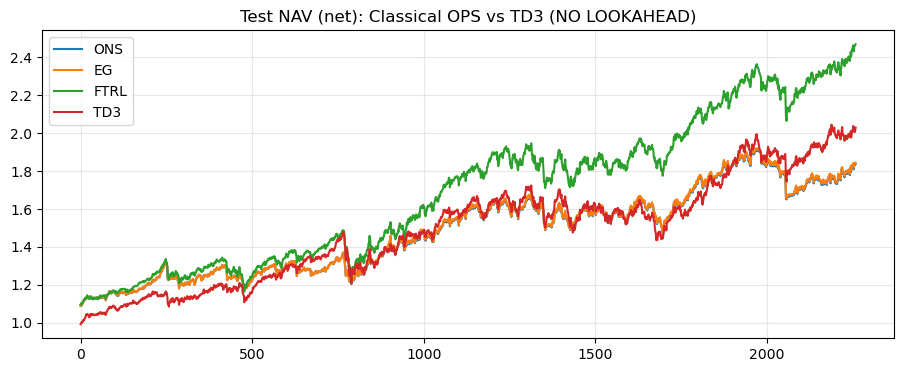

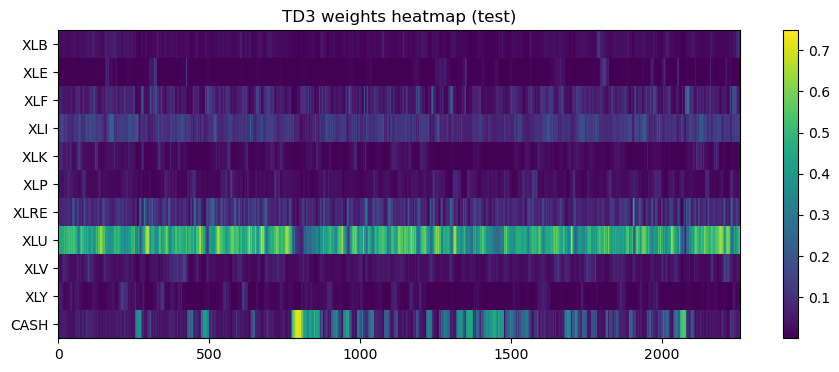

In [10]:
import numpy as np
import pandas as pd

# ============================================================
# 0) Utilities
# ============================================================
def price_relatives_from_prices(prices: pd.DataFrame) -> pd.DataFrame:
    x = prices / prices.shift(1)
    return x.dropna()

def project_to_simplex(v: np.ndarray, z: float = 1.0) -> np.ndarray:
    v = np.asarray(v, dtype=float).ravel()
    n = v.size
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u) - z
    ind = np.arange(1, n + 1)
    cond = u - cssv / ind > 0
    if not np.any(cond):
        w = np.zeros_like(v)
        w[np.argmax(v)] = z
        return w
    rho = ind[cond][-1]
    theta = cssv[cond][-1] / rho
    w = np.maximum(v - theta, 0.0)
    s = w.sum()
    if s <= 0:
        return np.ones_like(v) / n
    return w * (z / s)

def safe_softmax(a: np.ndarray, temp: float = 1.0) -> np.ndarray:
    a = np.asarray(a, dtype=float).ravel()
    a = a / max(temp, 1e-12)
    a = a - np.max(a)
    ea = np.exp(a)
    return ea / max(ea.sum(), 1e-12)

def annualize_stats(ret_s: pd.Series, periods_per_year: int = 252) -> dict:
    mu = ret_s.mean()
    vol = ret_s.std(ddof=0)
    ann_ret = (1.0 + mu) ** periods_per_year - 1.0
    ann_vol = vol * np.sqrt(periods_per_year)
    sharpe = (mu / (vol + 1e-12)) * np.sqrt(periods_per_year)
    return {"ann_return": float(ann_ret), "ann_vol": float(ann_vol), "sharpe": float(sharpe)}

def max_drawdown(nav: pd.Series) -> float:
    peak = nav.cummax()
    dd = nav / peak - 1.0
    return float(dd.min())

def realized_vol(ret_s: pd.Series, lookback: int = 20, periods_per_year: int = 252) -> pd.Series:
    return ret_s.rolling(lookback).std(ddof=0) * np.sqrt(periods_per_year)

def turnover_l1(w_new: np.ndarray, w_old: np.ndarray) -> float:
    return float(np.sum(np.abs(w_new - w_old)))

def align_series_to_index_no_lookahead(s: pd.Series, idx: pd.Index, name="VIX") -> pd.Series:
    """
    NO LOOKAHEAD:
    - reindex to idx
    - forward-fill only (uses past info)
    - leading NaN remain -> fill with 0.0 (neutral), NOT bfill (future leak)
    """
    s = s.copy()
    s.index = pd.to_datetime(s.index)
    s = s.sort_index()
    s = s.reindex(idx).ffill()
    s = s.astype(float)
    s = s.fillna(0.0)
    s.name = name
    return s

# optional loaders
def load_prices_yfinance(tickers, start="2011-01-01", end=None) -> pd.DataFrame:
    import yfinance as yf
    df = yf.download(tickers, start=start, end=end, auto_adjust=True, progress=False)["Close"]
    if isinstance(df, pd.Series):
        df = df.to_frame(tickers if isinstance(tickers, str) else tickers[0])
    df = df.dropna(how="all")
    return df

def load_vix_yfinance(start="2011-01-01", end=None) -> pd.Series:
    import yfinance as yf
    df = yf.download("^VIX", start=start, end=end, auto_adjust=True, progress=False)
    v = df["Close"] if "Close" in df.columns else df.iloc[:, 0]
    v = v.dropna()
    v.name = "VIX"
    return v

# ============================================================
# 1) Side-information signals (optional)
# ============================================================
def make_side_info_signals(prices: pd.DataFrame, mom_window=20, vol_window=20, clip=3.0) -> pd.DataFrame:
    logp = np.log(prices)
    mom = logp - logp.shift(mom_window)
    lr = logp.diff()
    vol = lr.rolling(vol_window).std(ddof=0)

    def cs_zscore(df):
        mu = df.mean(axis=1)
        sd = df.std(axis=1, ddof=0).replace(0, np.nan)
        return (df.sub(mu, axis=0)).div(sd, axis=0)

    mom_z = cs_zscore(mom).clip(-clip, clip)
    vol_z = cs_zscore(vol).clip(-clip, clip)
    score = (mom_z - vol_z).dropna()
    return score

def prior_from_signal(signal_row: np.ndarray, temp: float = 1.0) -> np.ndarray:
    return safe_softmax(signal_row, temp=temp)

# ============================================================
# 2) Classical OPS algorithms: EG / ONS / FTRL(log-barrier)
# ============================================================
class BaseOPS:
    def __init__(self, eps: float = 1e-12):
        self.eps = float(eps)
    def init_state(self, d: int):
        pass
    def step(self, w: np.ndarray, x_t: np.ndarray) -> np.ndarray:
        raise NotImplementedError

class EGOPS(BaseOPS):
    def __init__(self, eta: float = 0.05, eps: float = 1e-12):
        super().__init__(eps); self.eta=float(eta)
    def step(self, w, x_t):
        denom = max(float(w @ x_t), self.eps)
        g = -x_t / denom
        w_new = w * np.exp(-self.eta * g)
        w_new = w_new / max(w_new.sum(), self.eps)
        return w_new

class ONSOPS(BaseOPS):
    def __init__(self, eta: float = 0.3, delta: float = 1.0, clip_grad: float = 1e3, eps: float = 1e-12):
        super().__init__(eps)
        self.eta=float(eta); self.delta=float(delta); self.clip_grad=float(clip_grad)
        self.invA=None
    def init_state(self, d: int):
        self.invA = (1.0 / self.delta) * np.eye(d)
    def step(self, w, x_t):
        denom = max(float(w @ x_t), self.eps)
        g = -x_t / denom
        g = np.clip(g, -self.clip_grad, self.clip_grad)

        invA_g = self.invA @ g
        denom_sm = 1.0 + float(g @ invA_g)
        self.invA = self.invA - np.outer(invA_g, invA_g) / max(denom_sm, self.eps)

        w_new = w - self.eta * (self.invA @ g)
        return project_to_simplex(w_new)

class FTRLLogBarrierOPS(BaseOPS):
    """
    R(w) = -sum log w_i
    w_i = 1/(eta*G_i + nu), choose nu s.t. sum w_i = 1
    """
    def __init__(self, eta: float = 0.2, eps: float = 1e-12, nu_tol: float = 1e-12):
        super().__init__(eps)
        self.eta=float(eta); self.nu_tol=float(nu_tol)
        self.G=None
    def init_state(self, d: int):
        self.G = np.zeros(d, dtype=float)
    def _solve_nu(self, G: np.ndarray) -> float:
        etaG = self.eta * G
        lo = -np.min(etaG) + 1e-12
        hi = lo + 1.0

        def f(nu):
            denom = etaG + nu
            return np.sum(1.0 / denom) - 1.0

        while f(hi) > 0:
            hi *= 2.0
            if hi > 1e12:
                break

        for _ in range(200):
            mid = 0.5*(lo+hi)
            val = f(mid)
            if abs(val) < self.nu_tol:
                return mid
            if val > 0:
                lo = mid
            else:
                hi = mid
        return 0.5*(lo+hi)

    def step(self, w, x_t):
        denom = max(float(w @ x_t), self.eps)
        g = -x_t / denom
        self.G = self.G + g
        nu = self._solve_nu(self.G)

        w_new = 1.0 / (self.eta * self.G + nu)
        w_new = np.maximum(w_new, 0.0)
        w_new = w_new / max(w_new.sum(), self.eps)
        return w_new

# ============================================================
# 3) Shared post-processing
# ============================================================
def apply_prior_and_vol_targeting(
    w: np.ndarray,
    signal_row: np.ndarray,
    side_info_temp: float,
    blend_prior: float,
    cash_asset: bool,
    asset_names: list[str],
    target_vol_ann: float,
    vol_lookback: int,
    periods_per_year: int,
    ret_net_hist: list[float],
) -> np.ndarray:
    # (A) side-info prior blending
    if signal_row is not None:
        w_prior = prior_from_signal(signal_row, temp=side_info_temp)
        w = project_to_simplex((1.0 - blend_prior) * w + blend_prior * w_prior)

    # (B) vol targeting by mixing into CASH (de-risk only)
    if cash_asset and (target_vol_ann is not None) and (len(ret_net_hist) >= vol_lookback):
        past = np.asarray(ret_net_hist[-vol_lookback:], dtype=float)
        rv = float(np.std(past, ddof=0) * np.sqrt(periods_per_year))
        rv = max(rv, 1e-12)
        alpha = min(1.0, target_vol_ann / rv)

        cash_idx = asset_names.index("CASH")
        w_cash = np.zeros_like(w); w_cash[cash_idx] = 1.0
        w = project_to_simplex(alpha * w + (1.0 - alpha) * w_cash)

    return w

def finalize_outputs(
    x: pd.DataFrame,
    weights: np.ndarray,
    ret_gross: np.ndarray,
    ret_net: np.ndarray,
    turnover: np.ndarray,
    cost: np.ndarray,
    vol_lookback: int,
    periods_per_year: int,
    init_wealth: float,
) -> dict:
    idx = x.index
    w_df = pd.DataFrame(weights, index=idx, columns=x.columns)
    rg_s = pd.Series(ret_gross, index=idx, name="ret_gross")
    rn_s = pd.Series(ret_net, index=idx, name="ret_net")
    to_s = pd.Series(turnover, index=idx, name="turnover")
    c_s  = pd.Series(cost, index=idx, name="cost")

    nav_g = (1.0 + rg_s).cumprod() * init_wealth
    nav_n = (1.0 + rn_s).cumprod() * init_wealth
    nav_g.name = "nav_gross"
    nav_n.name = "nav_net"

    rv_n = realized_vol(rn_s, lookback=vol_lookback, periods_per_year=periods_per_year)
    rv_n.name = "realized_vol_ann"

    stats = annualize_stats(rn_s, periods_per_year=periods_per_year)
    summary = {
        **stats,
        "max_drawdown": float(max_drawdown(nav_n)),
        "avg_turnover": float(to_s.mean()),
        "total_cost": float(c_s.sum()),
        "final_nav_net": float(nav_n.iloc[-1]),
        "final_nav_gross": float(nav_g.iloc[-1]),
        "nobs": int(len(rn_s)),
    }

    return {
        "weights": w_df,
        "ret_gross": rg_s,
        "ret_net": rn_s,
        "nav_gross": nav_g,
        "nav_net": nav_n,
        "turnover": to_s,
        "cost": c_s,
        "realized_vol_ann": rv_n,
        "summary": summary,
        "price_relatives": x,
    }

# ============================================================
# 4) Classical backtest (NO LOOKAHEAD)
#    - signal is shifted(1) relative to x (P_t/P_{t-1})
# ============================================================
def run_ops_backtest_classical(
    prices: pd.DataFrame,
    algo: str = "ONS",                 # "ONS"|"EG"|"FTRL"
    cash_asset: bool = True,
    use_side_info: bool = True,
    side_info_temp: float = 1.0,
    blend_prior: float = 0.20,
    target_vol_ann: float = 0.10,
    vol_lookback: int = 20,
    periods_per_year: int = 252,
    commission_bps: float = 1.0,
    slippage_bps: float = 1.0,
    algo_params: dict = None,
    init_wealth: float = 1.0,
    w0: np.ndarray = None,
):
    prices = prices.dropna().copy()

    # raw signal uses prices up to t
    signal_raw = None
    if use_side_info:
        signal_raw = make_side_info_signals(prices)

    # x_t = P_t/P_{t-1}
    x = price_relatives_from_prices(prices)

    # ---- NO LOOKAHEAD: lag signal by 1 so that signal[t] uses info up to t-1 ----
    signal = None
    if use_side_info and (signal_raw is not None):
        signal = signal_raw.shift(1)

    # align & drop rows where shifted signal is not available
    if use_side_info and (signal is not None):
        signal = signal.reindex(x.index)
        valid = signal.dropna().index
        x = x.loc[valid]
        signal = signal.loc[valid]

    if cash_asset:
        x = x.copy()
        x["CASH"] = 1.0
        if use_side_info and (signal is not None):
            signal = signal.copy()
            signal["CASH"] = 0.0

    X = x.to_numpy(dtype=float)
    T, d = X.shape
    asset_names = list(x.columns)

    algo_params = {} if algo_params is None else dict(algo_params)
    au = algo.upper()
    if au == "ONS":
        model = ONSOPS(**algo_params); model.init_state(d)
    elif au == "EG":
        model = EGOPS(**algo_params)
    elif au == "FTRL":
        model = FTRLLogBarrierOPS(**algo_params); model.init_state(d)
    else:
        raise ValueError("classical algo must be 'ONS'|'EG'|'FTRL'")

    w = np.ones(d)/d if w0 is None else project_to_simplex(w0)

    weights = np.zeros((T, d))
    ret_gross = np.zeros(T)
    ret_net = np.zeros(T)
    turnover = np.zeros(T)
    cost = np.zeros(T)

    tc = (commission_bps + slippage_bps) * 1e-4
    ret_net_hist: list[float] = []

    for t in range(T):
        xt = X[t]

        # shifted signal[t] == raw signal[t-1] -> safe for earning x_t
        srow = None
        if use_side_info and (signal is not None):
            srow = signal.iloc[t].to_numpy(dtype=float)

        w_exec = apply_prior_and_vol_targeting(
            w=w,
            signal_row=srow,
            side_info_temp=side_info_temp,
            blend_prior=blend_prior,
            cash_asset=cash_asset,
            asset_names=asset_names,
            target_vol_ann=target_vol_ann,
            vol_lookback=vol_lookback,
            periods_per_year=periods_per_year,
            ret_net_hist=ret_net_hist,
        )

        growth = float(w_exec @ xt); growth = max(growth, 1e-12)
        rg = growth - 1.0

        to = 0.0 if t == 0 else turnover_l1(w_exec, weights[t-1])
        c = tc * to
        rn = rg - c

        weights[t] = w_exec
        ret_gross[t] = rg
        ret_net[t] = rn
        turnover[t] = to
        cost[t] = c
        ret_net_hist.append(rn)

        w = model.step(w_exec, xt)

    return finalize_outputs(
        x=x,
        weights=weights,
        ret_gross=ret_gross,
        ret_net=ret_net,
        turnover=turnover,
        cost=cost,
        vol_lookback=vol_lookback,
        periods_per_year=periods_per_year,
        init_wealth=init_wealth,
    )

# ============================================================
# 5) TD3 integration (NO LOOKAHEAD)
#    - signals are shifted(1) relative to x
#    - split has NO overlapping date
#    - VIX: ffill only, leading NaN -> 0.0
# ============================================================
def build_obs_matrix(
    x: pd.DataFrame,
    lookback: int,
    include_prev_w: bool,
    include_signal: bool,
    signal: pd.DataFrame,
    exog: np.ndarray = None,   # (T, k), aligned to x.index
):
    X = x.to_numpy(dtype=float)
    logx = np.log(np.maximum(X, 1e-12))
    T, d = X.shape

    sig_arr = None
    if include_signal and (signal is not None):
        sig_arr = signal.to_numpy(dtype=float)

    k = 0 if exog is None else int(exog.shape[1])

    def obs_dim_base():
        dim = lookback * d
        if include_prev_w:
            dim += d
        if include_signal and (sig_arr is not None):
            dim += d
        if exog is not None:
            dim += lookback * k
        return dim

    return X, logx, sig_arr, exog, obs_dim_base()

def simplex_from_action(action: np.ndarray, temp: float = 1.0) -> np.ndarray:
    return safe_softmax(action, temp=temp)

def run_td3_backtest_same_outputs(
    prices: pd.DataFrame,
    cash_asset: bool = True,
    use_side_info: bool = True,
    side_info_temp: float = 1.0,
    blend_prior: float = 0.20,
    target_vol_ann: float = 0.10,
    vol_lookback: int = 20,
    periods_per_year: int = 252,
    commission_bps: float = 1.0,
    slippage_bps: float = 1.0,
    init_wealth: float = 1.0,
    # TD3-specific
    obs_lookback: int = 20,
    action_temp: float = 1.0,
    include_prev_w: bool = True,
    include_signal_in_obs: bool = True,
    reward_type: str = "log_mv_turn",   # "log_net"|"net"|"log_mv_turn"
    # training
    split_date: str = None,
    total_timesteps: int = 500_000,
    seed: int = 0,
    td3_kwargs: dict = None,
    # VIX exogenous feature
    vix: pd.Series = None,
    vix_mode: str = "level",          # "level" | "logret" | "zlevel"
    include_vix_in_obs: bool = True,
    # history in observation
    hist_len: int = 5,
    include_hist_actions: bool = True,
    include_hist_rewards: bool = True,
    include_hist_returns: bool = True,
    include_port_state: bool = True,
    # mean-variance + turnover suppression
    mv_lambda: float = 5.0,
    mv_ewm_span: int = 60,
    mv_use_instant: bool = False,
    turn_lambda: float = 0.05,
    turn_mode: str = "l1",            # "l1" or "l2"
    # exploration noise for TD3
    action_noise_sigma: float = 0.15,  # std of Gaussian noise on actor output
):
    import gymnasium as gym
    from gymnasium import spaces
    from stable_baselines3 import TD3
    from stable_baselines3.common.noise import NormalActionNoise

    prices = prices.dropna().copy()

    # raw signals use prices up to t
    signal_raw = None
    if use_side_info:
        signal_raw = make_side_info_signals(prices)

    # x_t = P_t/P_{t-1}
    x = price_relatives_from_prices(prices)

    # ---- NO LOOKAHEAD: lag signal by 1 so signal[t] == raw signal[t-1] ----
    signal = None
    if use_side_info and (signal_raw is not None):
        signal = signal_raw.shift(1)

    if use_side_info and (signal is not None):
        signal = signal.reindex(x.index)
        valid = signal.dropna().index
        x = x.loc[valid]
        signal = signal.loc[valid]

    if cash_asset:
        x = x.copy()
        x["CASH"] = 1.0
        if use_side_info and (signal is not None):
            signal = signal.copy()
            signal["CASH"] = 0.0

    asset_names = list(x.columns)

    # VIX feature aligned to x.index (NO LOOKAHEAD: ffill only, leading NaN -> 0)
    vix_feat_full = None
    if include_vix_in_obs and (vix is not None):
        if isinstance(vix, pd.DataFrame):
            if vix.shape[1] != 1:
                raise ValueError("vix DataFrame must have exactly 1 column")
            vix_s = vix.iloc[:, 0].copy()
        else:
            vix_s = vix.copy()

        vix_al = align_series_to_index_no_lookahead(vix_s, x.index, name="VIX")

        if vix_mode == "level":
            vix_feat_full = pd.Series(vix_al.values, index=x.index, name="vix_f")
        elif vix_mode == "logret":
            vv = np.log(np.maximum(vix_al.values, 1e-12))
            dv = pd.Series(vv, index=x.index).diff().fillna(0.0).values
            vix_feat_full = pd.Series(dv, index=x.index, name="vix_f")
        elif vix_mode == "zlevel":
            m = vix_al.rolling(60).mean()
            s = vix_al.rolling(60).std(ddof=0).replace(0, np.nan)
            z = ((vix_al - m) / s).fillna(0.0)
            vix_feat_full = pd.Series(z.values, index=x.index, name="vix_f")
        else:
            raise ValueError("vix_mode must be 'level'|'logret'|'zlevel'")

    # split (NO overlap)
    if split_date is None:
        split_date = x.index[int(len(x) * 0.7)]
    split_date = pd.to_datetime(split_date)

    x_tr_full = x.loc[:split_date].copy()
    x_te = x.loc[split_date:].copy()

    if len(x_tr_full) > 0 and len(x_te) > 0 and x_tr_full.index[-1] == x_te.index[0]:
        x_tr = x_tr_full.iloc[:-1].copy()
    else:
        x_tr = x_tr_full

    if len(x_tr) <= obs_lookback + 5:
        raise ValueError("train set too short after removing overlap; choose earlier split_date or smaller obs_lookback.")
    if len(x_te) <= obs_lookback + 5:
        raise ValueError("test set too short; choose later split_date or smaller obs_lookback.")

    sig_tr = None
    sig_te = None
    if use_side_info and (signal is not None):
        sig_tr = signal.loc[x_tr.index].copy()
        sig_te = signal.loc[x_te.index].copy()

    ex_tr = None
    ex_te = None
    if vix_feat_full is not None:
        ex_tr = vix_feat_full.loc[x_tr.index].to_numpy(dtype=float).reshape(-1, 1)
        ex_te = vix_feat_full.loc[x_te.index].to_numpy(dtype=float).reshape(-1, 1)

    class PortfolioEnv(gym.Env):
        metadata = {"render_modes": []}

        def __init__(self, x_df: pd.DataFrame, sig_df: pd.DataFrame, exog: np.ndarray):
            super().__init__()
            self.x_df = x_df
            self.sig_df = sig_df

            self.X, self.logx, self.SIG, self.EXOG, self.obs_dim_base = build_obs_matrix(
                x=self.x_df,
                lookback=obs_lookback,
                include_prev_w=include_prev_w,
                include_signal=include_signal_in_obs,
                signal=self.sig_df,
                exog=exog,
            )
            self.T, self.d = self.X.shape

            self.hist_len = int(hist_len)
            extra = 0
            if include_hist_actions:
                extra += self.hist_len * self.d
            if include_hist_rewards:
                extra += self.hist_len
            if include_hist_returns:
                extra += self.hist_len
            if include_port_state:
                extra += 2
            self.obs_dim = int(self.obs_dim_base + extra)

            self.action_space = spaces.Box(low=-10.0, high=10.0, shape=(self.d,), dtype=np.float32)
            self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.obs_dim,), dtype=np.float32)

            self.tc = (commission_bps + slippage_bps) * 1e-4
            self.alpha = 2.0 / (float(mv_ewm_span) + 1.0)

            self.reset(seed=seed)

        def _port_state_features(self) -> np.ndarray:
            logw = float(self.log_wealth)
            if len(self.ret_net_hist) >= vol_lookback:
                past = np.asarray(self.ret_net_hist[-vol_lookback:], dtype=float)
                rv = float(np.std(past, ddof=0) * np.sqrt(periods_per_year))
            else:
                rv = 0.0
            return np.asarray([logw, rv], dtype=np.float32)

        def _get_obs(self) -> np.ndarray:
            t = self.t
            start = t - obs_lookback
            end = t

            # up to t-1
            win = self.logx[start:end, :]
            obs_parts = [win.reshape(-1)]

            if include_prev_w:
                obs_parts.append(self.w_prev.copy())

            # ---- NO LOOKAHEAD & no extra lag ----
            # SIG is already shifted(1) relative to x,
            # so SIG[t] corresponds to raw signal[t-1] and is available at decision time t.
            if include_signal_in_obs and (self.SIG is not None):
                obs_parts.append(self.SIG[t].copy())

            if self.EXOG is not None:
                ex_win = self.EXOG[start:end, :]
                obs_parts.append(ex_win.reshape(-1))

            if include_hist_actions:
                obs_parts.append(self.hist_actions.reshape(-1).copy())
            if include_hist_rewards:
                obs_parts.append(self.hist_rewards.copy())
            if include_hist_returns:
                obs_parts.append(self.hist_returns.copy())

            if include_port_state:
                obs_parts.append(self._port_state_features())

            obs = np.concatenate(obs_parts, axis=0).astype(np.float32)
            return obs

        def reset(self, seed=None, options=None):
            super().reset(seed=seed)
            self.t = obs_lookback
            self.w_prev = np.ones(self.d, dtype=float) / self.d

            self.ret_net_hist = []
            self.log_wealth = 0.0

            self.hist_actions = np.zeros((self.hist_len, self.d), dtype=np.float32)
            self.hist_rewards = np.zeros((self.hist_len,), dtype=np.float32)
            self.hist_returns = np.zeros((self.hist_len,), dtype=np.float32)

            self.mu_ewm = 0.0
            self.v_ewm = 0.0
            self.var_ewm = 0.0

            obs = self._get_obs()
            assert obs.shape[0] == self.obs_dim, (obs.shape, self.obs_dim)
            return obs, {}

        def _push_history(self, w_exec: np.ndarray, r_scalar: float, rn: float):
            if include_hist_actions:
                self.hist_actions[:-1] = self.hist_actions[1:]
                self.hist_actions[-1] = np.asarray(w_exec, dtype=np.float32)
            if include_hist_rewards:
                self.hist_rewards[:-1] = self.hist_rewards[1:]
                self.hist_rewards[-1] = np.float32(r_scalar)
            if include_hist_returns:
                self.hist_returns[:-1] = self.hist_returns[1:]
                self.hist_returns[-1] = np.float32(rn)

        def _turn_penalty(self, w_exec: np.ndarray, w_prev: np.ndarray) -> float:
            dw = w_exec - w_prev
            if turn_mode == "l2":
                return float(np.sum(dw * dw))
            return float(np.sum(np.abs(dw)))

        def _mv_penalty(self, l: float) -> float:
            var_prev = float(self.var_ewm)
            mu_prev = float(self.mu_ewm)

            if mv_use_instant:
                pen = 0.5 * float(mv_lambda) * (l - mu_prev) ** 2
            else:
                pen = 0.5 * float(mv_lambda) * var_prev

            a = float(self.alpha)
            self.mu_ewm = (1.0 - a) * self.mu_ewm + a * l
            self.v_ewm  = (1.0 - a) * self.v_ewm  + a * (l * l)
            self.var_ewm = max(self.v_ewm - self.mu_ewm * self.mu_ewm, 1e-12)

            return float(pen)

        def step(self, action):
            w_raw = simplex_from_action(np.asarray(action, dtype=float), temp=action_temp)

            # ---- NO LOOKAHEAD ----
            # SIG is shifted(1): SIG[t] == raw signal[t-1], safe to use for return x_t
            srow = None
            if use_side_info and (self.sig_df is not None):
                srow = self.SIG[self.t].copy()

            w_exec = apply_prior_and_vol_targeting(
                w=w_raw,
                signal_row=srow,
                side_info_temp=side_info_temp,
                blend_prior=blend_prior,
                cash_asset=cash_asset,
                asset_names=asset_names,
                target_vol_ann=target_vol_ann,
                vol_lookback=vol_lookback,
                periods_per_year=periods_per_year,
                ret_net_hist=self.ret_net_hist,
            )

            xt = self.X[self.t]
            growth = float(w_exec @ xt); growth = max(growth, 1e-12)
            rg = growth - 1.0

            to = turnover_l1(w_exec, self.w_prev)
            c = self.tc * to
            rn = rg - c

            l = float(np.log1p(rn))

            if reward_type == "log_net":
                r = l
            elif reward_type == "net":
                r = float(rn)
            elif reward_type == "log_mv_turn":
                mv_pen = self._mv_penalty(l)
                turn_pen = float(turn_lambda) * self._turn_penalty(w_exec, self.w_prev)
                r = l - mv_pen - turn_pen
            else:
                raise ValueError("reward_type must be 'log_net'|'net'|'log_mv_turn'")

            self.w_prev = w_exec
            self.ret_net_hist.append(rn)
            self.log_wealth += l
            self._push_history(w_exec=w_exec, r_scalar=r, rn=rn)

            self.t += 1
            terminated = (self.t >= self.T)
            truncated = False

            info = {"w_exec": w_exec, "ret_gross": rg, "ret_net": rn, "turnover": to, "cost": c}

            if terminated:
                obs = np.zeros(self.obs_dim, dtype=np.float32)
            else:
                obs = self._get_obs()
            return obs, r, terminated, truncated, info

    def rollout_collect(model, x_df: pd.DataFrame, sig_df: pd.DataFrame, exog: np.ndarray) -> dict:
        env = PortfolioEnv(x_df, sig_df, exog)
        obs, _ = env.reset()

        weights, ret_gross, ret_net, turnover, cost = [], [], [], [], []

        done = False
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, info = env.step(action)
            weights.append(info["w_exec"])
            ret_gross.append(info["ret_gross"])
            ret_net.append(info["ret_net"])
            turnover.append(info["turnover"])
            cost.append(info["cost"])
            done = terminated or truncated

        idx = x_df.index[obs_lookback:]
        x_eff = x_df.loc[idx]

        return finalize_outputs(
            x=x_eff,
            weights=np.asarray(weights),
            ret_gross=np.asarray(ret_gross),
            ret_net=np.asarray(ret_net),
            turnover=np.asarray(turnover),
            cost=np.asarray(cost),
            vol_lookback=vol_lookback,
            periods_per_year=periods_per_year,
            init_wealth=init_wealth,
        )

    # Train TD3
    td3_kwargs = {} if td3_kwargs is None else dict(td3_kwargs)

    env_tr = PortfolioEnv(x_tr, sig_tr, ex_tr)

    n_actions = env_tr.action_space.shape[-1]
    action_noise = NormalActionNoise(
        mean=np.zeros(n_actions, dtype=float),
        sigma=float(action_noise_sigma) * np.ones(n_actions, dtype=float),
    )

    model = TD3(
        policy="MlpPolicy",
        env=env_tr,
        seed=seed,
        action_noise=action_noise,
        verbose=0,
        **td3_kwargs
    )
    model.learn(total_timesteps=int(total_timesteps))

    out_tr = rollout_collect(model, x_tr, sig_tr, ex_tr)
    out_te = rollout_collect(model, x_te, sig_te, ex_te)
    return {"model": model, "train": out_tr, "test": out_te, "split_date_used": split_date}

# ============================================================
# 6) Comparison runner (Classical vs TD3)
# ============================================================
def compare_classical_vs_td3(
    prices: pd.DataFrame,
    split_date: str,
    common_kwargs: dict,
    classical_set=("ONS", "EG", "FTRL"),
    td3_kwargs: dict = None,
):
    outs = {}
    for a in classical_set:
        outs[a] = run_ops_backtest_classical(prices=prices, algo=a, **common_kwargs)

    pk = {} if td3_kwargs is None else dict(td3_kwargs)
    td3_pack = run_td3_backtest_same_outputs(
        prices=prices,
        split_date=split_date,
        **common_kwargs,
        **pk
    )
    outs["TD3"] = td3_pack["test"]

    # Align indices across methods
    common_idx = None
    for o in outs.values():
        idx = o["nav_net"].index
        common_idx = idx if common_idx is None else common_idx.intersection(idx)

    for k in list(outs.keys()):
        o = outs[k].copy()
        o["nav_net"] = o["nav_net"].loc[common_idx]
        o["nav_gross"] = o["nav_gross"].loc[common_idx]
        o["ret_net"] = o["ret_net"].loc[common_idx]
        o["ret_gross"] = o["ret_gross"].loc[common_idx]
        o["turnover"] = o["turnover"].loc[common_idx]
        o["cost"] = o["cost"].loc[common_idx]
        o["realized_vol_ann"] = o["realized_vol_ann"].loc[common_idx]
        o["weights"] = o["weights"].loc[common_idx]
        outs[k] = o

    rows = []
    for name, out in outs.items():
        s = out["summary"].copy()
        s["name"] = name
        rows.append(s)
    df_sum = pd.DataFrame(rows).set_index("name").sort_values("sharpe", ascending=False)

    return outs, df_sum, td3_pack


# ============================================================
# Example usage
# ============================================================
if __name__ == "__main__":
    import matplotlib.pyplot as plt

    TICKERS = ["XLB", "XLE", "XLF", "XLI", "XLK", "XLP", "XLU", "XLV", "XLY", "XLRE"]
    START = "2011-01-01"
    END = None
    SPLIT_DATE = "2017-01-01"

    prices = load_prices_yfinance(TICKERS, start=START, end=END)
    vix_series = load_vix_yfinance(start=START, end=END)

    common_kwargs = dict(
        cash_asset=True,
        use_side_info=True,
        side_info_temp=1.0,
        blend_prior=0.20,
        target_vol_ann=0.10,
        vol_lookback=20,
        commission_bps=1.0,
        slippage_bps=1.0,
        init_wealth=1.0,
        periods_per_year=252,
    )

    td3_kwargs = dict(
        obs_lookback=20,
        action_temp=1.0,
        include_prev_w=True,
        include_signal_in_obs=True,

        reward_type="log_mv_turn",
        mv_lambda=5.0,
        mv_ewm_span=60,
        mv_use_instant=False,
        turn_lambda=0.05,
        turn_mode="l1",

        total_timesteps=5_000,
        seed=0,

        td3_kwargs=dict(
            learning_rate=3e-4,
            buffer_size=300_000,
            learning_starts=10_000,
            batch_size=256,
            train_freq=(1, "step"),
            gradient_steps=1,
            tau=0.005,
            gamma=0.99,
            policy_delay=2,
            target_policy_noise=0.2,
            target_noise_clip=0.5,
        ),
        action_noise_sigma=0.15,

        vix=vix_series,
        vix_mode="level",
        include_vix_in_obs=True,

        hist_len=5,
        include_hist_actions=True,
        include_hist_rewards=True,
        include_hist_returns=True,
        include_port_state=True,
    )

    outs, df_sum, td3_pack = compare_classical_vs_td3(
        prices=prices,
        split_date=SPLIT_DATE,
        common_kwargs=common_kwargs,
        td3_kwargs=td3_kwargs,
    )

    print(df_sum)

    plt.figure(figsize=(11, 4))
    for k, out in outs.items():
        plt.plot(out["nav_net"].values, label=k)
    plt.title("Test NAV (net): Classical OPS vs TD3 (NO LOOKAHEAD)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

    w = outs["TD3"]["weights"]
    plt.figure(figsize=(11, 4))
    plt.imshow(w.T.values, aspect="auto", interpolation="nearest")
    plt.yticks(range(len(w.columns)), w.columns)
    plt.title("TD3 weights heatmap (test)")
    plt.colorbar()
    plt.show()
